# Lectura y preparación de datos EEG en formato BIDS para modelo end-to-end

En esta celda vamos a:

1. Definir la ruta al directorio BIDS donde descargaste el dataset (`ds004504`).
2. Listar los sujetos disponibles (`sub-001` … `sub-088`).
3. Utilizar **mne-bids** para cargar cada señal Raw de EEG.
4. Dividir cada grabación continua en ventanas de **2 segundos** (1 000 muestras a 500 Hz).
5. Crear un `Dataset` de PyTorch que devuelva tensores de forma `(n_channels, n_times)` por cada ventana, listo para entrenar tu modelo en GPU.

Una vez ejecutada, podrás alimentar un `DataLoader` en tu bucle de entrenamiento.


In [46]:
!pip install entropy

In [13]:
import os
import numpy as np
import pandas as pd
from scipy import signal
import mne
from mne.time_frequency import psd_array_welch

# ————— Rutas —————
bids_root      = r'C:\Users\cesar\Desktop\projects\neurocheck'
deriv_root     = os.path.join(bids_root, 'derivatives')
participants_tsv = os.path.join(bids_root, 'participants.tsv')
hp_csv         = r'C:\Users\cesar\Desktop\projects\neurocheck\best_configurations.csv'

# ————— Cargo mejor configuración —————
hp_df = pd.read_csv(hp_csv)
# Asumo que ya está ordenado de mayor a menor accuracy
best = hp_df.iloc[0]
win_sec, bp_order, nperseg = best['win_sec'], int(best['bp_order']), int(best['nperseg'])
print(f"Usando mejores hiperparámetros: win_sec={win_sec}, bp_order={bp_order}, nperseg={nperseg}")

# ————— Carga participantes —————
participants = (pd.read_csv(participants_tsv, sep='\t')
                  .rename(columns={'participant_id':'subject','Group':'group'}))

# ————— Función de extracción —————
def extract_features(win_sec, bp_order, nperseg):
    sfreq    = 500
    win_samp = int(win_sec * sfreq)
    bands    = {'delta':(0.5,4), 'theta':(4,8), 'alpha':(8,12), 'beta':(12,30)}
    # Filtros
    b_notch, a_notch = signal.iirnotch(50.0, Q=30.0, fs=sfreq)
    sos_bp = signal.butter(bp_order, [0.5,45.0],
                          btype='bandpass', fs=sfreq, output='sos')
    rows = []
    for sub in sorted(os.listdir(deriv_root)):
        eeg_dir = os.path.join(deriv_root, sub, 'eeg')
        sets = [f for f in os.listdir(eeg_dir) if f.endswith('_eeg.set')]
        if not sets:
            continue
        raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, sets[0]),
                                     preload=True, verbose=False)
        raw.resample(sfreq, npad='auto', verbose=False)
        data = raw.get_data()  # (n_ch, n_times)
        # Filtrado canal a canal
        for ch in range(data.shape[0]):
            data[ch] = signal.filtfilt(b_notch, a_notch, data[ch])
            data[ch] = signal.sosfiltfilt(sos_bp, data[ch])
        n_win = data.shape[1] // win_samp
        for w in range(n_win):
            epoch = data[:, w*win_samp:(w+1)*win_samp]
            feat = {'subject': sub, 'window': w}
            # Potencia en bandas
            for name,(fmin,fmax) in bands.items():
                n_fft     = min(nperseg, epoch.shape[1])
                n_overlap = n_fft // 2
                psd, _ = psd_array_welch(
                    epoch, sfreq,
                    fmin=fmin, fmax=fmax,
                    n_fft=n_fft, n_overlap=n_overlap,
                    verbose=False
                )
                bp = psd.mean(axis=1)
                feat[f'{name}_pow_mean'] = bp.mean()
                feat[f'{name}_pow_std']  = bp.std()
            rows.append(feat)
    df = pd.DataFrame(rows)
    # Añadir columna de grupo
    df = df.merge(participants[['subject','group']], on='subject', how='left')
    return df

# ————— Extraer con la mejor configuración y guardar —————
df_best = extract_features(win_sec, bp_order, nperseg)
out_path = r'C:\Users\cesar\Desktop\projects\neurocheck\eeg_features_besthp.csv'
df_best.to_csv(out_path, index=False)
print(f"CSV generado con mejores hiperparámetros en:\n{out_path}")

Usando mejores hiperparámetros: win_sec=3.0, bp_order=4, nperseg=256


C:\Users\cesar\AppData\Local\Temp\ipykernel_15156\2246406365.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, sets[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_15156\2246406365.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, sets[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_15156\2246406365.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, sets[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_15156\2246406365.py:40: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of fil

CSV generado con mejores hiperparámetros en:
C:\Users\cesar\Desktop\projects\neurocheck\eeg_features_besthp.csv


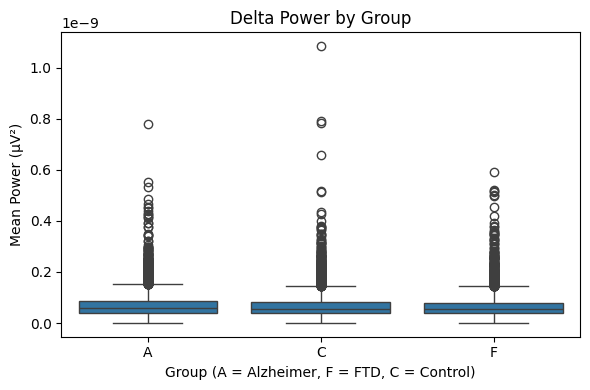

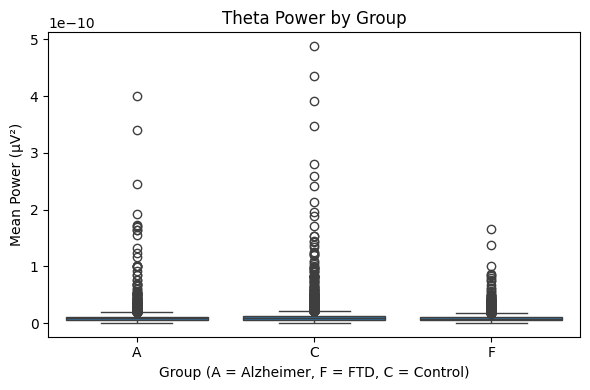

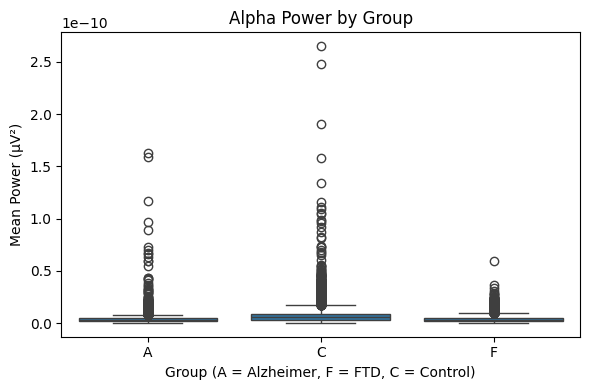

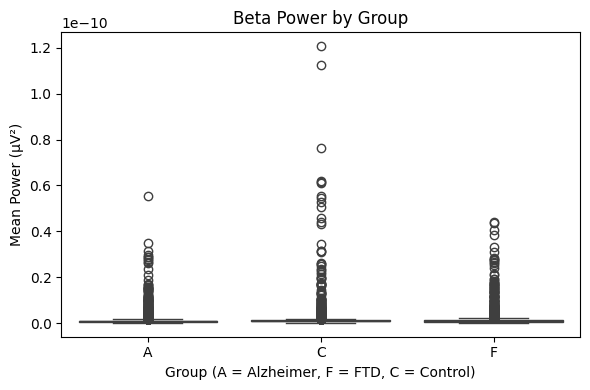

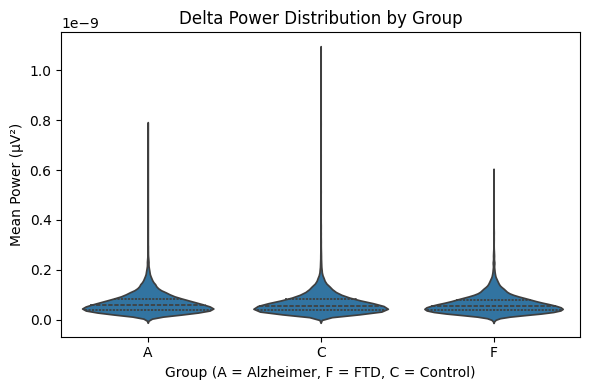

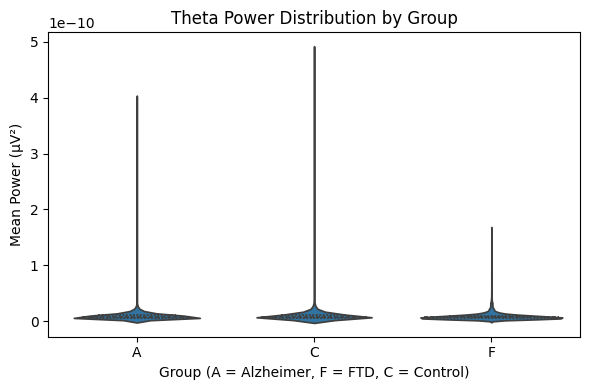

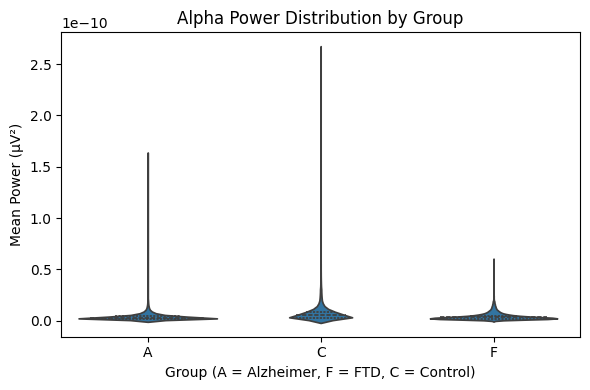

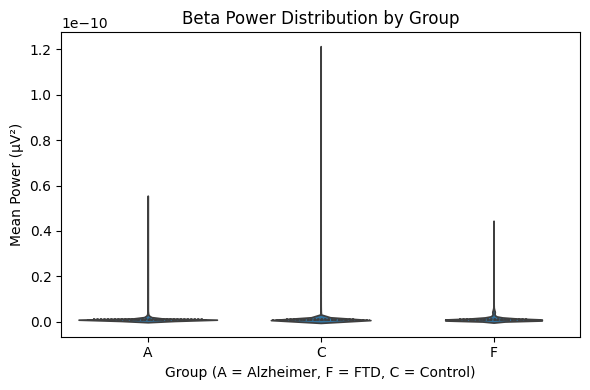

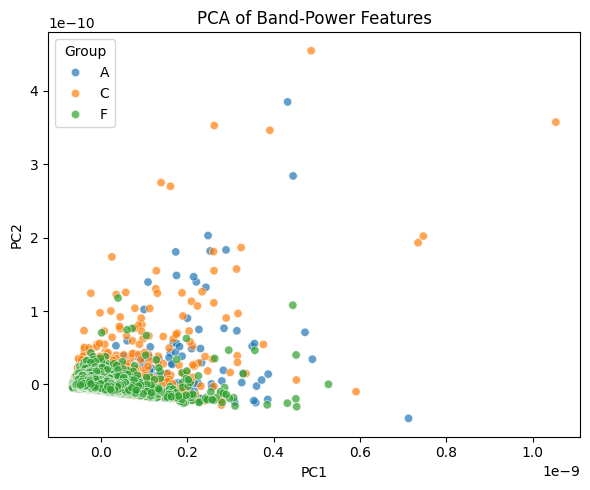

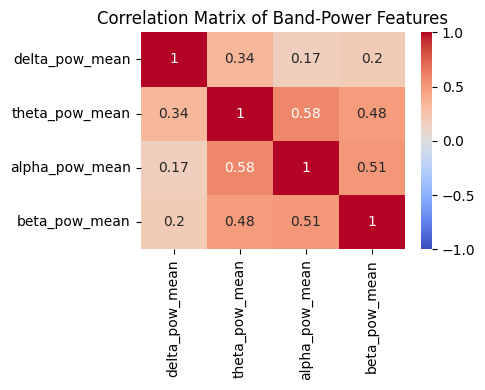

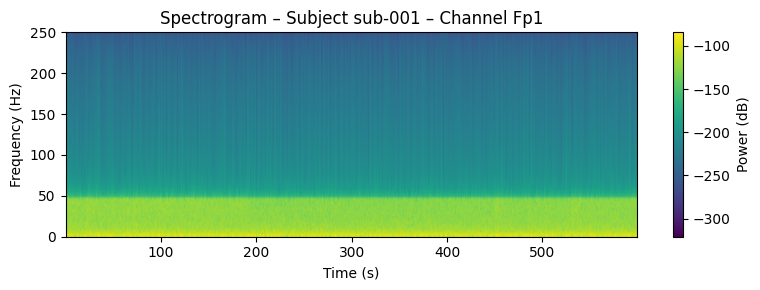

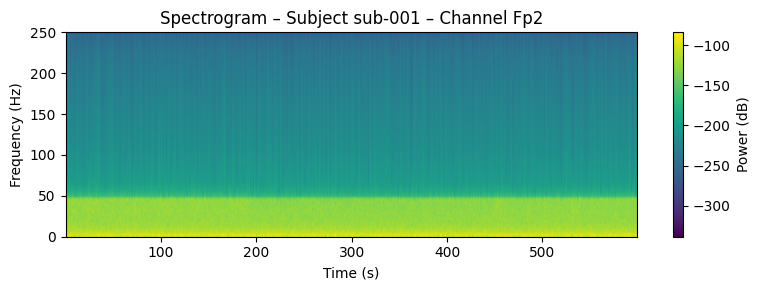

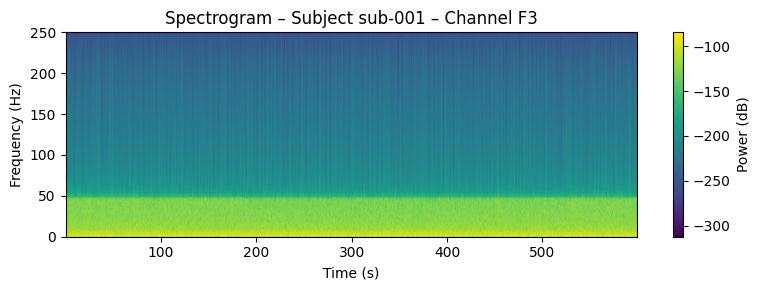

In [14]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from sklearn.decomposition import PCA

# ————— Rutas —————
bids_root  = r'C:\Users\cesar\Desktop\projects\neurocheck'
deriv_root = os.path.join(bids_root, 'derivatives')
csv_path   = r'C:\Users\cesar\Desktop\projects\neurocheck\eeg_advanced_features.csv'
participants_path = os.path.join(bids_root, 'participants.tsv')

# ————— Parámetros —————
bands     = ['delta','theta','alpha','beta']
group_col = 'group'
sfreq     = 500  # Hz

# ————— Carga y merge —————
df_feats = pd.read_csv(csv_path)
# Carga participantes y renombra para merge
participants = pd.read_csv(participants_path, sep='\t')
participants = participants.rename(columns={
    'participant_id':'subject',
    'Group':'group'
})
# Añade columna 'group' a df_feats
df = df_feats.merge(participants[['subject', 'group']], on='subject', how='left')

# ————— 1) BOXPLOTS de potencia media por banda y grupo —————
for band in bands:
    plt.figure(figsize=(6,4))
    sns.boxplot(x='group', y=f'{band}_pow_mean', data=df)
    plt.title(f'{band.capitalize()} Power by Group')
    plt.xlabel('Group (A = Alzheimer, F = FTD, C = Control)')
    plt.ylabel('Mean Power (µV²)')
    plt.tight_layout()
    plt.show()

# ————— 2) VIOLIN PLOTS de potencia media por banda y grupo —————
for band in bands:
    plt.figure(figsize=(6,4))
    sns.violinplot(x='group', y=f'{band}_pow_mean', data=df, inner='quartile')
    plt.title(f'{band.capitalize()} Power Distribution by Group')
    plt.xlabel('Group (A = Alzheimer, F = FTD, C = Control)')
    plt.ylabel('Mean Power (µV²)')
    plt.tight_layout()
    plt.show()

# ————— 3) PCA de powers —————
features = [f'{b}_pow_mean' for b in bands]
pca = PCA(n_components=2)
pcs = pca.fit_transform(df[features].fillna(0))
pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
pc_df['group'] = df['group'].values

plt.figure(figsize=(6,5))
sns.scatterplot(x='PC1', y='PC2', hue='group', data=pc_df, alpha=0.7)
plt.title('PCA of Band-Power Features')
plt.xlabel('PC1'); plt.ylabel('PC2')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# ————— 4) HEATMAP de correlación —————
corr = df[features].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Band-Power Features')
plt.tight_layout()
plt.show()

# ————— 5) ESPECTROGRAMAS de ejemplo —————
sample_sub = df['subject'].iloc[0]
set_path   = os.path.join(deriv_root, sample_sub, 'eeg',
                          f'{sample_sub}_task-eyesclosed_eeg.set')
raw = mne.io.read_raw_eeglab(set_path, preload=True, verbose=False)
raw.filter(0.5, 45, verbose=False)
data = raw.get_data()

channels_to_plot = [0,1,2]
nfft    = 256
noverlap= 128

for ch in channels_to_plot:
    plt.figure(figsize=(8,3))
    plt.specgram(data[ch], Fs=sfreq, NFFT=nfft, noverlap=noverlap, cmap='viridis')
    plt.title(f'Spectrogram – Subject {sample_sub} – Channel {raw.ch_names[ch]}')
    plt.xlabel('Time (s)'); plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power (dB)')
    plt.tight_layout()
    plt.show()


In [29]:
import pandas as pd


# 2. Columnas de power
bands = ['delta_pow_mean','theta_pow_mean','alpha_pow_mean','beta_pow_mean']

# 3. Aplicar limpieza IQR por banda, globalmente o por grupo
df_clean = df.copy()
for col in bands:
    Q1 = df_clean[col].quantile(0.25)
    Q3 = df_clean[col].quantile(0.75)
    IQR = Q3 - Q1
    lower, upper = Q1 - 1.5*IQR, Q3 + 1.5*IQR
    df_clean = df_clean[(df_clean[col] >= lower) & (df_clean[col] <= upper)]

print("Filas antes:", len(df), "— filas después de IQR:", len(df_clean))
df = df_clean.copy()

Filas antes: 34876 — filas después de IQR: 28272


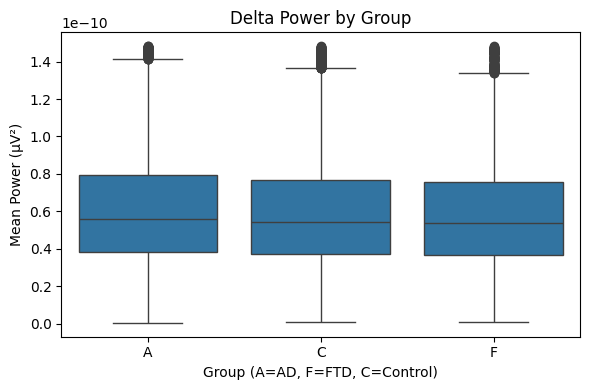

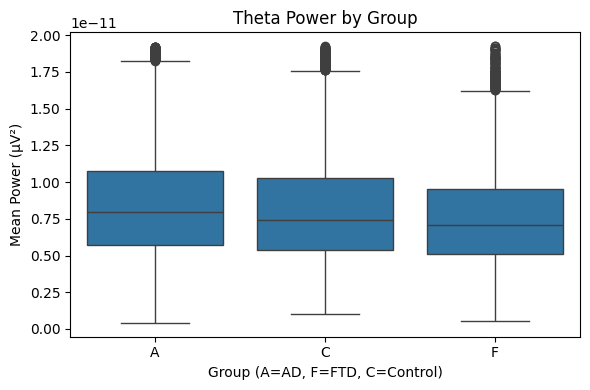

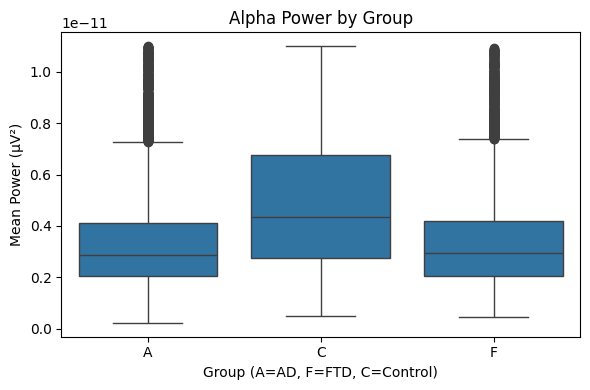

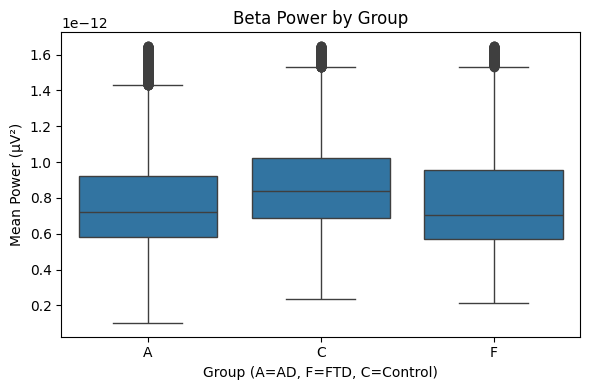

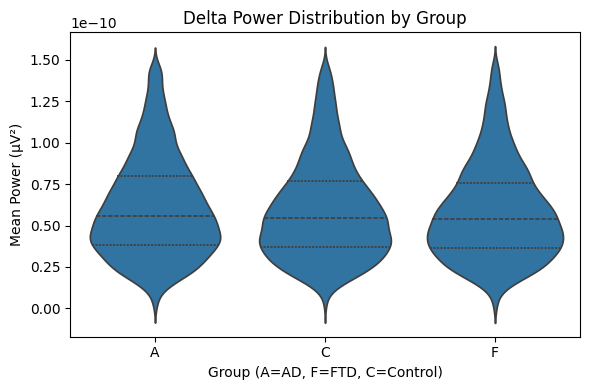

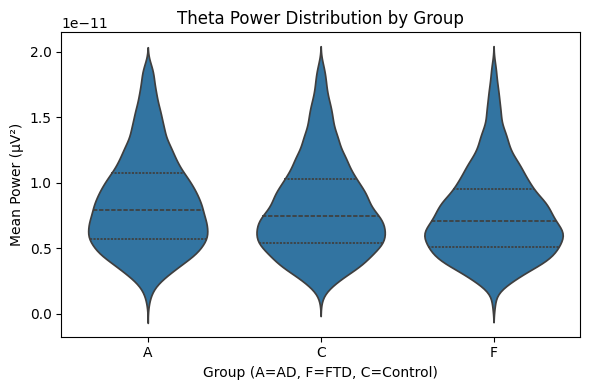

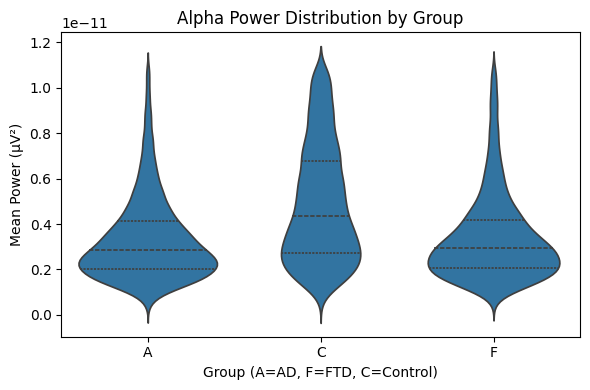

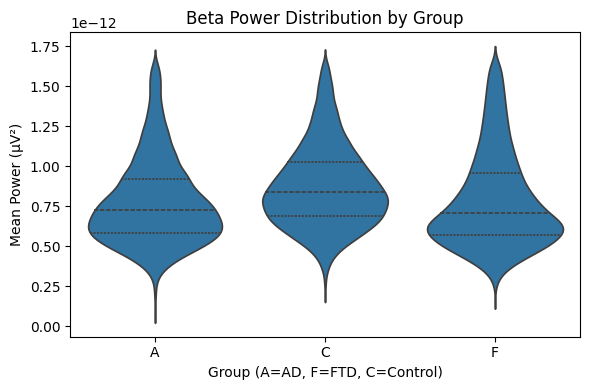

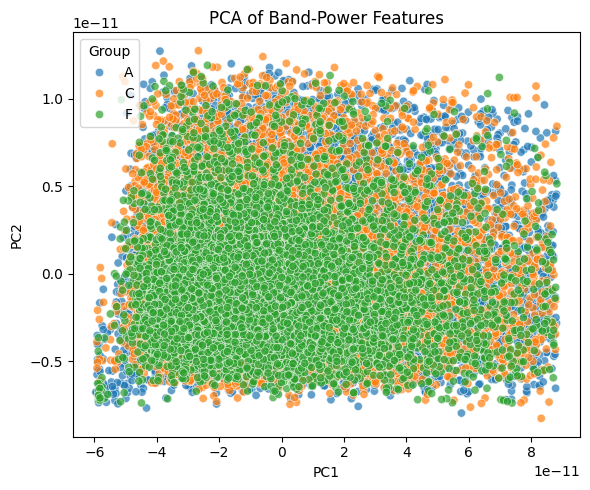

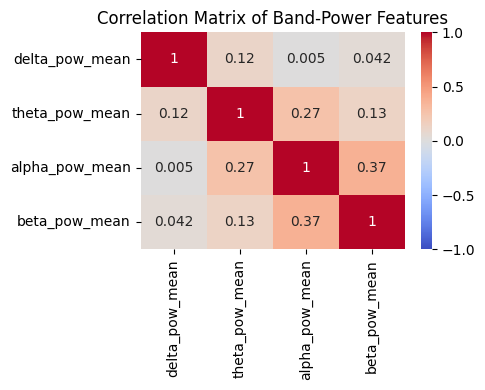

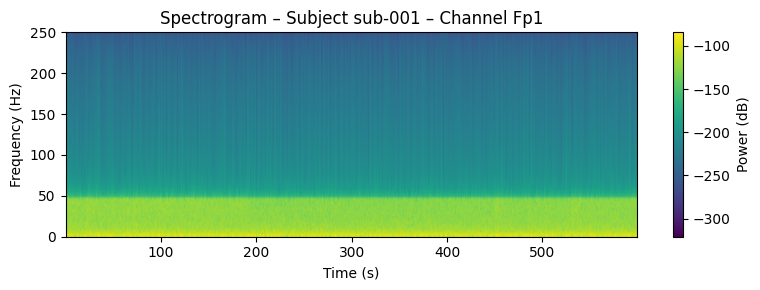

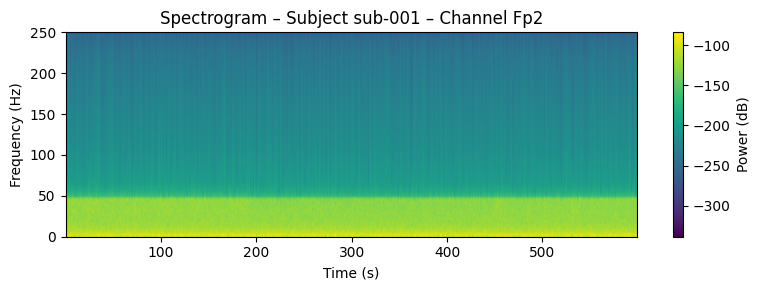

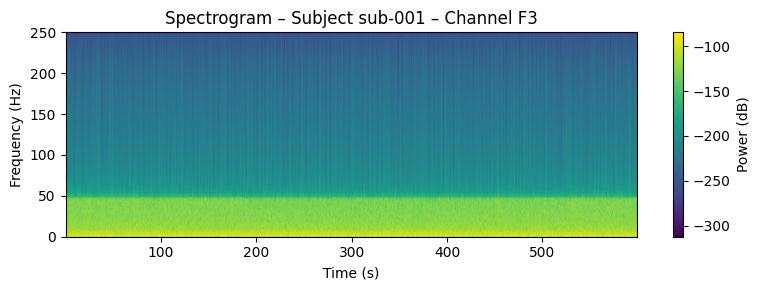

In [30]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import mne
from sklearn.decomposition import PCA

# —————— Parámetros ——————
bands      = ['delta','theta','alpha','beta']
group_col  = 'group'
sfreq      = 500  # Hz, asumiendo que tus raw ya están a 500 Hz


# 1) BOXPLOTS de potencia media en cada banda, por grupo
for band in bands:
    plt.figure(figsize=(6,4))
    sns.boxplot(x=group_col, y=f'{band}_pow_mean', data=df)
    plt.title(f'{band.capitalize()} Power by Group')
    plt.xlabel('Group (A=AD, F=FTD, C=Control)')
    plt.ylabel('Mean Power (µV²)')
    plt.tight_layout()
    plt.show()

# 2) VIOLIN PLOTS de potencia media en cada banda, por grupo
for band in bands:
    plt.figure(figsize=(6,4))
    sns.violinplot(x=group_col, y=f'{band}_pow_mean', data=df, inner='quartile')
    plt.title(f'{band.capitalize()} Power Distribution by Group')
    plt.xlabel('Group (A=AD, F=FTD, C=Control)')
    plt.ylabel('Mean Power (µV²)')
    plt.tight_layout()
    plt.show()

# 3) PCA sobre [delta_mean, theta_mean, alpha_mean, beta_mean]
features = [f'{b}_pow_mean' for b in bands]
pca = PCA(n_components=2)
pcs = pca.fit_transform(df[features].fillna(0))
pc_df = pd.DataFrame(pcs, columns=['PC1','PC2'])
pc_df[group_col] = df[group_col].values

plt.figure(figsize=(6,5))
sns.scatterplot(x='PC1', y='PC2', hue=group_col, data=pc_df, alpha=0.7)
plt.title('PCA of Band-Power Features')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend(title='Group')
plt.tight_layout()
plt.show()

# 4) HEATMAP de correlación entre las potencias medias de las cuatro bandas
corr = df[features].corr()
plt.figure(figsize=(5,4))
sns.heatmap(corr, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix of Band-Power Features')
plt.tight_layout()
plt.show()

# 5) ESPECTROGRAMAS de ejemplo para 3 canales de un sujeto
sample_sub = df['subject'].iloc[0]
set_path   = os.path.join(deriv_root, sample_sub, 'eeg',
                          f'{sample_sub}_task-eyesclosed_eeg.set')
raw = mne.io.read_raw_eeglab(set_path, preload=True, verbose=False)
raw.filter(0.5, 45, verbose=False)
data = raw.get_data()

channels_to_plot = [0,1,2]  # puedes cambiar a otros índices
nfft    = 256
noverlap= 128

for ch in channels_to_plot:
    plt.figure(figsize=(8,3))
    plt.specgram(data[ch], Fs=sfreq, NFFT=nfft, noverlap=noverlap, cmap='viridis')
    plt.title(f'Spectrogram – Subject {sample_sub} – Channel {raw.ch_names[ch]}')
    plt.xlabel('Time (s)')
    plt.ylabel('Frequency (Hz)')
    plt.colorbar(label='Power (dB)')
    plt.tight_layout()
    plt.show()

In [16]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# ————— Rutas —————
bids_root  = r'C:\Users\cesar\Desktop\projects\neurocheck'
participants_path = os.path.join(bids_root, 'participants.tsv')
csv_path   = r'C:\Users\cesar\Desktop\projects\neurocheck\eeg_advanced_features.csv'

# ————— Carga de datos —————
df_feats    = pd.read_csv(csv_path)
participants = pd.read_csv(participants_path, sep='\t')
participants = participants.rename(columns={
    'participant_id':'subject',
    'Group':'group'
})

# ————— Merge para añadir la columna 'group' —————
df = df_feats.merge(participants[['subject','group']], on='subject', how='left')

# ————— Separación de X e y —————
X = df.drop(columns=['subject','group','window'])
y = df['group']

# ————— Estandarización de X —————
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ————— Codificación de etiquetas —————
le = LabelEncoder()
y_encoded = le.fit_transform(y)
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapeo de etiquetas:", label_mapping)

# ————— División Train/Test (80/20) con estratificación —————
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded,
    test_size=0.2,
    stratify=y_encoded,
    random_state=42
)

# ————— (Opcional) División Train/Val (60/20/20) —————
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train,
    test_size=0.25,        # 0.25 × 0.8 = 0.2 del total
    stratify=y_train,
    random_state=42
)

# ————— Resumen de shapes —————
print("Shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape},  y_test:  {y_test.shape}")


Mapeo de etiquetas: {'A': np.int64(0), 'C': np.int64(1), 'F': np.int64(2)}
Shapes:
  X_train: (20925, 17), y_train: (20925,)
  X_val:   (6975, 17),   y_val:   (6975,)
  X_test:  (6976, 17),  y_test:  (6976,)


In [18]:
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# 1) Split train/val/test (igual a tu código):
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.10, random_state=42, stratify=y_encoded
)
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.20, random_state=42, stratify=y_train_val
)
print(f"Sizes → Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# 2) Definimos clasificadores y sus grids
models = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7, 9],
            "model__weights": ["uniform", "distance"]
        }
    },
    "Linear SVM": {
        "model": SVC(kernel="linear"),
        "params": {
            "model__C": [0.01, 0.1, 1, 10]
        }
    },
    "RBF SVM": {
        "model": SVC(kernel="rbf"),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__gamma": ["scale", "auto", 0.01, 0.1, 1]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__max_depth": [None, 5, 10],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "params": {
            "model__hidden_layer_sizes": [(100,), (256,128), (512,256,128)],
            "model__alpha": [0.0001, 0.001, 0.01],
            "model__learning_rate": ["constant", "adaptive"]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.5, 1.0]
        }
    }
}

results = {}

for name, mp in models.items():
    print(f"\n=== Tuning {name} ===")
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", mp["model"])
    ])
    grid = GridSearchCV(
        pipe,
        mp["params"],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    # Solo entrenamos sobre train para no “mirar” la val
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    print(f"--> Best params: {grid.best_params_}")
    # Validación
    y_pred_val = best.predict(X_val)
    print("Val Accuracy:", accuracy_score(y_val, y_pred_val))
    # Evaluación final en test
    y_pred = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"[{name}] Test Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("Classification Report:\n", classification_report(y_test, y_pred))
    results[name] = acc

# 3) Resumen de accuracies
print("\n=== Summary of Test Accuracies ===")
for name, acc in results.items():
    print(f"{name:<15} → {acc:.4f}")




Sizes → Train: 25110, Val: 6278, Test: 3488

=== Tuning KNN ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [24]:
!pip install umap

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Created wheel for umap: filename=umap-0.1.1-py3-none-any.whl size=3586 sha256=5934ab3105e34d7e874f3793836ba7bf0608ff4ee1974a198ab0378fcac3ade5
  Stored in directory: c:\users\cesar\appdata\local\pip\cache\wheels\72\1e\42\a9322736ec046a637487005e6b84c94617d9ac0bdb5159eeb7
Successfully built umap


In [33]:
!pip install umap-learn

  Using cached umap_learn-0.5.7-py3-none-any.whl.metadata (21 kB)
  Using cached numba-0.60.0-cp39-cp39-win_amd64.whl.metadata (2.8 kB)
  Using cached pynndescent-0.5.13-py3-none-any.whl.metadata (6.8 kB)
  Using cached llvmlite-0.43.0-cp39-cp39-win_amd64.whl.metadata (4.9 kB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\cesar\\anaconda3\\envs\\pytorch\\lib\\site-packages\\numpy-1.26.4.dist-info\\METADATA'



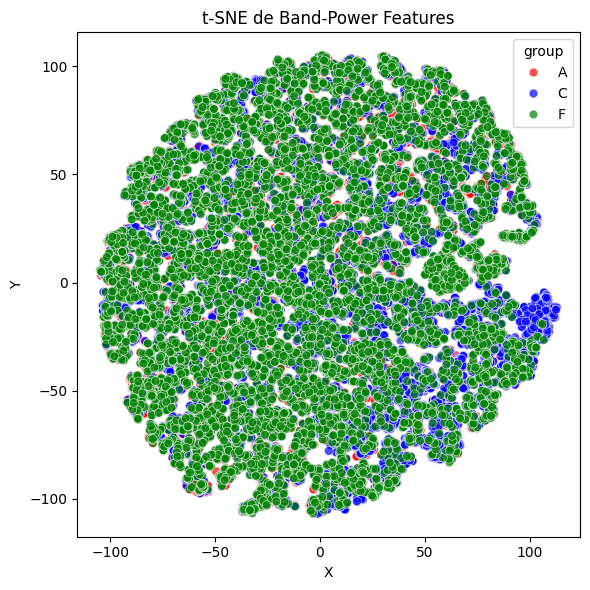

In [36]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
# — opcional: StandardScaler
from sklearn.preprocessing import StandardScaler

# 1) Cargo tus features + etiqueta de grupo
df = pd.read_csv('eeg_advanced_features.csv')
parts = (
    pd.read_csv('participants.tsv', sep='\t')
      .rename(columns={'participant_id':'subject','Group':'group'})
)
df = df.merge(parts[['subject','group']], on='subject')

# 2) Me quedo sólo con las potencias medias de banda
X = df[['delta_pow_mean','theta_pow_mean','alpha_pow_mean','beta_pow_mean']].fillna(0).values
y = df['group'].values

# 3) (Opcional) Escalo antes de t-SNE
X = StandardScaler().fit_transform(X)

# 4) t-SNE a 2D
tsne = TSNE(n_components=2, perplexity=30, random_state=42, n_jobs=-1)
emb = tsne.fit_transform(X)

# 5) Ploteo
vis = pd.DataFrame(emb, columns=['X','Y'])
vis['group'] = y

plt.figure(figsize=(6,6))
sns.scatterplot(
    data=vis,
    x='X', y='Y',
    hue='group',
    palette={'A':'r','F':'g','C':'b'},
    alpha=0.7, s=40
)
plt.title('t-SNE de Band-Power Features')
plt.tight_layout()
plt.show()


In [50]:
!pip uninstall numpy -y
!pip install numpy
!pip install lightgbm




Found existing installation: numpy 1.26.4


error: uninstall-no-record-file

× Cannot uninstall numpy 1.26.4
╰─> The package's contents are unknown: no RECORD file was found for numpy.

hint: You might be able to recover from this via: pip install --force-reinstall --no-deps numpy==1.26.4


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\cesar\\anaconda3\\envs\\pytorch\\lib\\site-packages\\numpy-1.26.4.dist-info\\METADATA'



  Using cached lightgbm-4.6.0-py3-none-win_amd64.whl.metadata (17 kB)


ERROR: Could not install packages due to an OSError: [Errno 2] No such file or directory: 'c:\\users\\cesar\\anaconda3\\envs\\pytorch\\lib\\site-packages\\numpy-1.26.4.dist-info\\METADATA'



In [60]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
try:
    from lightgbm import LGBMClassifier
    HAVE_LGBM = True
except ImportError:
    print("⚠️ lightgbm no encontrado, se omitirá ese modelo.")
    HAVE_LGBM = False

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

# ————— Rutas —————
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
participants_path = os.path.join(bids_root, 'participants.tsv')
features_path     = os.path.join(bids_root, 'eeg_advanced_features.csv')

# ————— Carga y merge de datos —————
df_feats = pd.read_csv(features_path)
participants = (
    pd.read_csv(participants_path, sep='\t')
      .rename(columns={'participant_id':'subject','Group':'group'})
)
df = df_feats.merge(participants[['subject','group']], on='subject', how='left')

# ————— Montaje de X, y —————
X = df.drop(columns=['subject','group','window'])
y = df['group']

# ————— Escalado y codificación —————
# …––– código previo de carga y merge …–––

# Estandarizar X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Ajustar LabelEncoder y codificar y
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Ahora sí podemos ver le.classes_ en la instancia 'le'
label_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print("Mapeo de etiquetas:", label_mapping)

# ———— División Train/Val/Test ————
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.15,
    stratify=y_encoded, random_state=42
)
# … resto de splits, pipelines y GridSearchCV …

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)
print(f"Shapes → Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ————— Definición de modelos y grids —————
models = {
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 6],
            "model__learning_rate": [0.01, 0.1],
        }
    },
    "SVM (RBF)": {
        "model": SVC(kernel="rbf", class_weight='balanced'),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__gamma": ["scale", 0.01, 0.1]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "ExtraTrees": {
        "model": ExtraTreesClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "params": {
            "model__hidden_layer_sizes": [(100,), (256,128)],
            "model__alpha": [0.0001, 0.001],
            "model__learning_rate": ["constant", "adaptive"]
        }
    }
}

# Incluir LightGBM solo si está instalado:
if HAVE_LGBM:
    models["LightGBM"] = {
        "model": LGBMClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [-1, 10],
            "model__learning_rate": [0.01, 0.1],
        }
    }

results = {}

# ————— Grid Search & evaluación —————
for name, cfg in models.items():
    print(f"\n=== Ajustando {name} ===")
    pipe = Pipeline([
        ("scaler", StandardScaler()),  # importante para SVM y MLP
        ("model", cfg["model"])
    ])
    grid = GridSearchCV(
        pipe,
        cfg["params"],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    best = grid.best_estimator_
    print(f"Mejores hiperparámetros: {grid.best_params_}")

    # Validación
    y_pred_val = best.predict(X_val)
    print("Val Accuracy:", accuracy_score(y_val, y_pred_val))

    # Test final
    y_pred_test = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred_test)
    print(f"[{name}] Test Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
    print("Classification Report:\n", classification_report(y_test, y_pred_test))

    results[name] = acc

# ————— Resumen de resultados —————
print("\n=== Test Accuracies ===")
for name, acc in results.items():
    print(f"{name:<12} → {acc:.4f}")


⚠️ lightgbm no encontrado, se omitirá ese modelo.
Mapeo de etiquetas: {'A': np.int64(0), 'C': np.int64(1), 'F': np.int64(2)}
Shapes → Train: (24411, 17), Val: (5233, 17), Test: (5232, 17)

=== Ajustando XGBoost ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [22:20:37] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 100}
Val Accuracy: 0.6416969233709153
[XGBoost] Test Accuracy: 0.6355
Confusion Matrix:
 [[1594  441  148]
 [ 415 1305   86]
 [ 563  254  426]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.73      0.67      2183
           1       0.65      0.72      0.69      1806
           2       0.65      0.34      0.45      1243

    accuracy                           0.64      5232
   macro avg       0.64      0.60      0.60      5232
weighted avg       0.64      0.64      0.62      5232


=== Ajustando SVM (RBF) ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores hiperparámetros: {'model__C': 10, 'model__gamma': 'scale'}
Val Accuracy: 0.5954519396139881
[SVM (RBF)] Test Accuracy: 0.5835
Confusion Matrix:
 [[1209  424  550]
 [ 280 1215  311]
 [ 377  237  629]]
Classification Report:
               precision    re

In [61]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# === 1. Prepare data loaders (tensors en CPU) ===
X_train_t = torch.from_numpy(X_train).float()    # NO .to(device)
y_train_t = torch.from_numpy(y_train).long()
X_val_t   = torch.from_numpy(X_val).float()
y_val_t   = torch.from_numpy(y_val).long()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).long()

train_ds = TensorDataset(X_train_t, y_train_t)
val_ds   = TensorDataset(X_val_t,   y_val_t)
test_ds  = TensorDataset(X_test_t,  y_test_t)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=64, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=64, shuffle=False, num_workers=0)

# === 2. En tu función train_epoch y eval_model, mueve a GPU por batch ===
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)      # aquí pasas a GPU
        optimizer.zero_grad()
        preds = model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)  # también aquí
            preds = model(xb)
            _, pred_labels = preds.max(1)
            correct += (pred_labels == yb).sum().item()
    return correct / len(loader.dataset)

# === 2. MLP classifier ===
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes=4):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        return self.net(x)

# Instantiate model, loss, optimizer
input_dim = X_train.shape[1]
mlp = MLPClassifier(input_dim).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp.parameters(), lr=1e-3)


# Run training
patience = 5            # si 5 épocas seguidas no mejora la val_acc, paramos
best_val_acc = 0.0
epochs_no_improve = 0

for epoch in range(1, 51):
    train_loss = train_epoch(mlp, train_loader, optimizer, criterion)
    val_acc    = eval_model(mlp, val_loader)
    print(f"[MLP] Epoch {epoch:02d} – Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Comprueba mejora
    if val_acc > best_val_acc + 1e-4:  
        best_val_acc    = val_acc
        epochs_no_improve = 0
        torch.save(mlp.state_dict(), "best_mlp.pt")
    else:
        epochs_no_improve += 1

    # Early stopping
    if epochs_no_improve >= patience:
        print(f"No improvement for {patience} epochs, stopping early at epoch {epoch}.")
        break

# Cargar el mejor modelo y evaluar en test
mlp.load_state_dict(torch.load("best_mlp.pt"))
test_acc = eval_model(mlp, test_loader)
print(f"[MLP] Test Accuracy: {test_acc:.4f}")


# === 3. 1D-CNN classifier on feature vector ===
# Here we treat the 180-dim feature vector as a “sequence” of length 180 with 1 channel.
class CNN1DClassifier(nn.Module):
    def __init__(self, seq_len, num_classes=4):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
        )
        # compute flattened size after pooling
        pooled_len = seq_len // 4
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * pooled_len, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, num_classes)
        )
    def forward(self, x):
        # x shape: (batch, features)
        x = x.unsqueeze(1)               # (batch, 1, features)
        x = self.encoder(x)              # (batch, 64, features/4)
        return self.classifier(x)

# Instantiate, loss, optimizer
cnn = CNN1DClassifier(seq_len=input_dim).to(device)
optimizer_c = optim.Adam(cnn.parameters(), lr=1e-3)

# Training loop is same as above, just swap model & optimizer
best_val_acc = 0
for epoch in range(1, 51):
    train_loss = train_epoch(cnn, train_loader, optimizer_c, criterion)
    val_acc = eval_model(cnn, val_loader)
    print(f"[1D-CNN] Epoch {epoch:02d} – Train Loss: {train_loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn.state_dict(), "best_cnn1d.pt")

cnn.load_state_dict(torch.load("best_cnn1d.pt"))
test_acc = eval_model(cnn, test_loader)
print(f"[1D-CNN] Test Accuracy: {test_acc:.4f}")


Using device: cuda
[MLP] Epoch 01 – Train Loss: 1.0007, Val Acc: 0.5660
[MLP] Epoch 02 – Train Loss: 0.9435, Val Acc: 0.5731
[MLP] Epoch 03 – Train Loss: 0.9246, Val Acc: 0.5960
[MLP] Epoch 04 – Train Loss: 0.9056, Val Acc: 0.6031
[MLP] Epoch 05 – Train Loss: 0.8949, Val Acc: 0.6037
[MLP] Epoch 06 – Train Loss: 0.8853, Val Acc: 0.6062
[MLP] Epoch 07 – Train Loss: 0.8797, Val Acc: 0.6111
[MLP] Epoch 08 – Train Loss: 0.8723, Val Acc: 0.6155
[MLP] Epoch 09 – Train Loss: 0.8662, Val Acc: 0.6128
[MLP] Epoch 10 – Train Loss: 0.8631, Val Acc: 0.6153
[MLP] Epoch 11 – Train Loss: 0.8608, Val Acc: 0.6178
[MLP] Epoch 12 – Train Loss: 0.8560, Val Acc: 0.6193
[MLP] Epoch 13 – Train Loss: 0.8532, Val Acc: 0.6226
[MLP] Epoch 14 – Train Loss: 0.8524, Val Acc: 0.6195
[MLP] Epoch 15 – Train Loss: 0.8478, Val Acc: 0.6209
[MLP] Epoch 16 – Train Loss: 0.8460, Val Acc: 0.6218
[MLP] Epoch 17 – Train Loss: 0.8420, Val Acc: 0.6211
[MLP] Epoch 18 – Train Loss: 0.8448, Val Acc: 0.6285
[MLP] Epoch 19 – Train Loss

In [62]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# ================================
# 0. Device and DataLoader Setup
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Preparamos tensores en CPU y moveremos a GPU por batch
X_train_t = torch.from_numpy(X_train).float()
y_train_t = torch.from_numpy(y_train).long()
X_val_t   = torch.from_numpy(X_val).float()
y_val_t   = torch.from_numpy(y_val).long()
X_test_t  = torch.from_numpy(X_test).float()
y_test_t  = torch.from_numpy(y_test).long()

train_loader = DataLoader(TensorDataset(X_train_t, y_train_t),
                          batch_size=32, shuffle=True,  num_workers=0)
val_loader   = DataLoader(TensorDataset(X_val_t,   y_val_t),
                          batch_size=64, shuffle=False, num_workers=0)
test_loader  = DataLoader(TensorDataset(X_test_t,  y_test_t),
                          batch_size=64, shuffle=False, num_workers=0)

input_dim   = X_train.shape[1]
num_classes = int(torch.unique(y_train_t).numel())

# ====================================
# 1. Training / Evaluation Functions
# ====================================
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            _, pl = preds.max(1)
            correct += (pl == yb).sum().item()
    return correct / len(loader.dataset)

criterion = nn.CrossEntropyLoss()

# ============
# 2. MLP
# ============
class MLPClassifier(nn.Module):
    def __init__(self, dim, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, C)
        )
    def forward(self, x):
        return self.net(x)

mlp     = MLPClassifier(input_dim, num_classes).to(device)
opt_mlp = optim.Adam(mlp.parameters(), lr=1e-3)

best_val_acc = 0.0
EPOCHS = 50
for epoch in range(1, EPOCHS+1):
    loss    = train_epoch(mlp, train_loader, opt_mlp, criterion)
    val_acc = eval_model(mlp, val_loader)
    print(f"[MLP] Epoch {epoch:02d}/{EPOCHS} – Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(mlp.state_dict(), "best_mlp.pt")

mlp.load_state_dict(torch.load("best_mlp.pt"))
print(f"[MLP] Test Acc: {eval_model(mlp, test_loader):.4f}\n")

# ================
# 3. 1D-CNN
# ================
class CNN1DClassifier(nn.Module):
    def __init__(self, L, C):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
        )
        pooled_len = L // 4
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * pooled_len, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, C)
        )
    def forward(self, x):
        x = x.unsqueeze(1)  # (batch,1,features)
        x = self.encoder(x)
        return self.classifier(x)

cnn1d   = CNN1DClassifier(input_dim, num_classes).to(device)
opt_cnn = optim.Adam(cnn1d.parameters(), lr=1e-3)

best_val_acc = 0.0
for epoch in range(1, EPOCHS+1):
    loss    = train_epoch(cnn1d, train_loader, opt_cnn, criterion)
    val_acc = eval_model(cnn1d, val_loader)
    print(f"[1D-CNN] Epoch {epoch:02d}/{EPOCHS} – Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(cnn1d.state_dict(), "best_cnn1d.pt")

cnn1d.load_state_dict(torch.load("best_cnn1d.pt"))
print(f"[1D-CNN] Test Acc: {eval_model(cnn1d, test_loader):.4f}\n")

# ============
# 4. LSTM
# ============
class LSTMClassifier(nn.Module):
    def __init__(self, L, C, hidden=64):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden,
                            num_layers=1, batch_first=True,
                            bidirectional=True)
        self.fc   = nn.Sequential(
            nn.Linear(hidden*2, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, C)
        )
    def forward(self, x):
        x = x.unsqueeze(-1)       # (batch,features,1)
        out,_ = self.lstm(x)      # (batch,features,hidden*2)
        feat  = out.mean(dim=1)   # global average
        return self.fc(feat)

lstm     = LSTMClassifier(input_dim, num_classes).to(device)
opt_lstm = optim.Adam(lstm.parameters(), lr=1e-3)

best_val_acc = 0.0
for epoch in range(1, EPOCHS+1):
    loss    = train_epoch(lstm, train_loader, opt_lstm, criterion)
    val_acc = eval_model(lstm, val_loader)
    print(f"[LSTM] Epoch {epoch:02d}/{EPOCHS} – Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(lstm.state_dict(), "best_lstm.pt")

lstm.load_state_dict(torch.load("best_lstm.pt"))
print(f"[LSTM] Test Acc: {eval_model(lstm, test_loader):.4f}\n")

# ======================================
# 5. Fast Transformer (no early stop)
# ======================================
class FastTransformerClassifier(nn.Module):
    def __init__(self, L, d_model, nhead, nlayers, C):
        super().__init__()
        self.embed     = nn.Linear(1, d_model)
        self.pos_embed = nn.Parameter(torch.randn(1, L, d_model))
        layer = nn.TransformerEncoderLayer(
            d_model=d_model, nhead=nhead,
            dim_feedforward=d_model*2,
            dropout=0.1, activation='relu',
            batch_first=True
        )
        self.transform = nn.TransformerEncoder(layer, num_layers=nlayers)
        self.fc        = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, C)
        )
    def forward(self, x):
        x = x.unsqueeze(-1)             # (batch,seq_len,1)
        x = self.embed(x) + self.pos_embed
        x = self.transform(x)           # (batch,seq_len,d_model)
        feat = x.mean(dim=1)            # global average
        return self.fc(feat)

transf    = FastTransformerClassifier(
    L=input_dim, d_model=32, nhead=2, nlayers=1, C=num_classes
).to(device)
opt_trans = optim.Adam(transf.parameters(), lr=5e-4)

best_val_acc = 0.0
for epoch in range(1, 21):  # 20 epochs fijos
    loss    = train_epoch(transf, train_loader, opt_trans, criterion)
    val_acc = eval_model(transf, val_loader)
    print(f"[Transformer] Epoch {epoch:02d}/20 – Loss: {loss:.4f}, Val Acc: {val_acc:.4f}")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(transf.state_dict(), "best_transf.pt")

transf.load_state_dict(torch.load("best_transf.pt"))
print(f"[Transformer] Test Acc: {eval_model(transf, test_loader):.4f}")


Using device: cuda
[MLP] Epoch 01/50 – Loss: 0.9808, Val Acc: 0.5666
[MLP] Epoch 02/50 – Loss: 0.9375, Val Acc: 0.5893
[MLP] Epoch 03/50 – Loss: 0.9104, Val Acc: 0.5977
[MLP] Epoch 04/50 – Loss: 0.8987, Val Acc: 0.5991
[MLP] Epoch 05/50 – Loss: 0.8895, Val Acc: 0.6006
[MLP] Epoch 06/50 – Loss: 0.8803, Val Acc: 0.6069
[MLP] Epoch 07/50 – Loss: 0.8764, Val Acc: 0.6105
[MLP] Epoch 08/50 – Loss: 0.8685, Val Acc: 0.6159
[MLP] Epoch 09/50 – Loss: 0.8657, Val Acc: 0.6128
[MLP] Epoch 10/50 – Loss: 0.8592, Val Acc: 0.6188
[MLP] Epoch 11/50 – Loss: 0.8600, Val Acc: 0.6163
[MLP] Epoch 12/50 – Loss: 0.8568, Val Acc: 0.6180
[MLP] Epoch 13/50 – Loss: 0.8547, Val Acc: 0.6193
[MLP] Epoch 14/50 – Loss: 0.8519, Val Acc: 0.6190
[MLP] Epoch 15/50 – Loss: 0.8476, Val Acc: 0.6216
[MLP] Epoch 16/50 – Loss: 0.8474, Val Acc: 0.6226
[MLP] Epoch 17/50 – Loss: 0.8440, Val Acc: 0.6211
[MLP] Epoch 18/50 – Loss: 0.8424, Val Acc: 0.6186
[MLP] Epoch 19/50 – Loss: 0.8408, Val Acc: 0.6283
[MLP] Epoch 20/50 – Loss: 0.838

In [64]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
from sklearn.svm import SVC

# ————— Rutas —————
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
participants_path = os.path.join(bids_root, 'participants.tsv')
features_path     = os.path.join(bids_root, 'eeg_advanced_features.csv')

# ————— Carga y merge de datos —————
df_feats = pd.read_csv(features_path)
participants = (
    pd.read_csv(participants_path, sep='\t')
      .rename(columns={'participant_id':'subject','Group':'group'})
)
df = df_feats.merge(participants[['subject','group']], on='subject', how='left')

# ————— Preparación de X e y —————
X = df.drop(columns=['subject','group','window']).values
y_group = df['group']                     # etiquetas 'A','F','C'
y_bin   = (y_group != 'C').astype(int)    # 0=Control, 1=Enfermo

# ————— Escalado —————
X_scaled = StandardScaler().fit_transform(X)

# ————— División Train/Val/Test (70/15/15) —————
# dividimos X, y_bin y y_group al mismo tiempo
X_temp, X_test, \
y_temp_bin, y_test_bin, \
y_temp_group, y_test_group = train_test_split(
    X_scaled, y_bin, y_group,
    test_size=0.15,
    stratify=y_bin,
    random_state=42
)

X_train, X_val, \
y_train_bin, y_val_bin, \
y_train_group, y_val_group = train_test_split(
    X_temp, y_temp_bin, y_temp_group,
    test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 total
    stratify=y_temp_bin,
    random_state=42
)

print(f"Shapes → Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ————— Paso 1: “Control vs Enfermo” con XGBoost —————
pipe1 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42))
])
param_grid1 = {
    "model__n_estimators": [100, 200],
    "model__max_depth": [3, 6],
    "model__learning_rate": [0.01, 0.1]
}
grid1 = GridSearchCV(pipe1, param_grid1, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid1.fit(X_train, y_train_bin)
best1 = grid1.best_estimator_

print("\n--- Paso 1: Control vs Enfermo ---")
print("Hiperparámetros óptimos:", grid1.best_params_)
print("Val Acc:", accuracy_score(y_val_bin, best1.predict(X_val)))
print("Test Acc:", accuracy_score(y_test_bin, best1.predict(X_test)))
print("Confusion mat:\n", confusion_matrix(y_test_bin, best1.predict(X_test)))
print("Report:\n", classification_report(y_test_bin, best1.predict(X_test)))

# ————— Paso 2: “AD vs FTD” sobre enfermos detectados —————
# Filtramos train/val/test a solo los enfermos
mask_tr = (y_train_bin == 1)
X_tr_enf = X_train[mask_tr]
y_tr_enf = y_train_group[mask_tr].map({'A':0,'F':1}).values

mask_val = (y_val_bin == 1)
X_val_enf = X_val[mask_val]
y_val_enf = y_val_group[mask_val].map({'A':0,'F':1}).values

mask_test = (y_test_bin == 1)
X_test_enf = X_test[mask_test]
y_test_enf = y_test_group[mask_test].map({'A':0,'F':1}).values

pipe2 = Pipeline([
    ("scaler", StandardScaler()),
    ("model", SVC(kernel="rbf", class_weight='balanced', random_state=42))
])
param_grid2 = {
    "model__C": [0.1, 1, 10],
    "model__gamma": ["scale", 0.01, 0.1]
}
grid2 = GridSearchCV(pipe2, param_grid2, cv=5, scoring="accuracy", n_jobs=-1, verbose=1)
grid2.fit(X_tr_enf, y_tr_enf)
best2 = grid2.best_estimator_

print("\n--- Paso 2: Alzheimer vs FTD ---")
print("Hiperparámetros óptimos:", grid2.best_params_)
print("Val Acc:", accuracy_score(y_val_enf, best2.predict(X_val_enf)))
print("Test Acc:", accuracy_score(y_test_enf, best2.predict(X_test_enf)))
print("Confusion mat:\n", confusion_matrix(y_test_enf, best2.predict(X_test_enf)))
print("Report:\n", classification_report(y_test_enf, best2.predict(X_test_enf)))


Shapes → Train: (24411, 17), Val: (5233, 17), Test: (5232, 17)
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [23:12:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



--- Paso 1: Control vs Enfermo ---
Hiperparámetros óptimos: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 100}
Val Acc: 0.7706860309573859
Test Acc: 0.7859327217125383
Confusion mat:
 [[1130  676]
 [ 444 2982]]
Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1806
           1       0.82      0.87      0.84      3426

    accuracy                           0.79      5232
   macro avg       0.77      0.75      0.76      5232
weighted avg       0.78      0.79      0.78      5232

Fitting 5 folds for each of 9 candidates, totalling 45 fits

--- Paso 2: Alzheimer vs FTD ---
Hiperparámetros óptimos: {'model__C': 0.1, 'model__gamma': 0.01}
Val Acc: 0.6637478108581436
Test Acc: 0.6523642732049036
Confusion mat:
 [[1869  287]
 [ 904  366]]
Report:
               precision    recall  f1-score   support

           0       0.67      0.87      0.76      2156
           1       0.56      0.29      0.38  

In [66]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# ————— Rutas —————
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
participants_path = os.path.join(bids_root, 'participants.tsv')
csv_path          = os.path.join(bids_root, 'eeg_advanced_features.csv')

# ————— Carga de datos —————
df_feats     = pd.read_csv(csv_path)
participants = pd.read_csv(participants_path, sep='\t').rename(columns={
    'participant_id':'subject',
    'Group':'group'
})

# ————— Merge para añadir la columna 'group' —————
df = df_feats.merge(
    participants[['subject','group']],
    on='subject',
    how='left'
)

# ————— Creamos etiqueta binaria: 0=Control (C), 1=Enfermo (A o F) —————
df['y_bin'] = (df['group'] != 'C').astype(int)

# ————— Separación de X e y_bin —————
X     = df.drop(columns=['subject','group','window','y_bin'])
y_bin = df['y_bin']

# ————— Estandarización de X —————
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ————— División Train/Test (80/20) con estratificación sobre y_bin —————
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled,
    y_bin,
    test_size=0.2,
    stratify=y_bin,
    random_state=42
)

# ————— División Train/Val (60/20/20) —————
X_train, X_val, y_train, y_val = train_test_split(
    X_train,
    y_train,
    test_size=0.25,        # 0.25 × 0.8 = 0.2 del total
    stratify=y_train,
    random_state=42
)

# ————— Resumen de shapes —————
print("Binario (Control vs Enfermo):")
print("Shapes:")
print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"  X_val:   {X_val.shape},   y_val:   {y_val.shape}")
print(f"  X_test:  {X_test.shape},  y_test:  {y_test.shape}")


Binario (Control vs Enfermo):
Shapes:
  X_train: (20925, 17), y_train: (20925,)
  X_val:   (6975, 17),   y_val:   (6975,)
  X_test:  (6976, 17),  y_test:  (6976,)


In [70]:
import numpy as np
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier

# ————— Asumiendo que ya tienes X_scaled y y_bin del split binario —————
# X_train, X_val, X_test, y_train, y_val, y_test

print(f"Sizes → Train: {X_train.shape[0]}, Val: {X_val.shape[0]}, Test: {X_test.shape[0]}")

# ————— Definimos clasificadores y sus grids —————
models = {
    "KNN": {
        "model": KNeighborsClassifier(),
        "params": {
            "model__n_neighbors": [3, 5, 7, 9],
            "model__weights": ["uniform", "distance"]
        }
    },
    "Linear SVM": {
        "model": SVC(kernel="linear", class_weight='balanced'),
        "params": {
            "model__C": [0.01, 0.1, 1, 10]
        }
    },
    "RBF SVM": {
        "model": SVC(kernel="rbf", class_weight='balanced'),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__gamma": ["scale", "auto", 0.01, 0.1, 1]
        }
    },
    "Random Forest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__max_depth": [None, 5, 10],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "params": {
            "model__hidden_layer_sizes": [(100,), (256,128), (512,256,128)],
            "model__alpha": [0.0001, 0.001, 0.01],
            "model__learning_rate": ["constant", "adaptive"]
        }
    },
    "AdaBoost": {
        "model": AdaBoostClassifier(random_state=42),
        "params": {
            "model__n_estimators": [50, 100, 200],
            "model__learning_rate": [0.5, 1.0]
        }
    }
}

results = {}

for name, mp in models.items():
    print(f"\n=== Tuning {name} ===")
    pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("model", mp["model"])
    ])
    grid = GridSearchCV(
        pipe,
        mp["params"],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    # Solo entrenamos sobre train para no “mirar” la val
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    print(f"--> Best params: {grid.best_params_}")
    # Validación
    y_pred_val = best.predict(X_val)
    print("Val Accuracy:", accuracy_score(y_val, y_pred_val))
    # Evaluación final en test
    y_pred_test = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred_test)
    print(f"[{name}] Test Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
    print("Classification Report:\n", classification_report(y_test, y_pred_test))
    results[name] = acc

# ————— Resumen de accuracies —————
print("\n=== Summary of Test Accuracies ===")
for name, acc in results.items():
    print(f"{name:<15} → {acc:.4f}")


Sizes → Train: 24411, Val: 5233, Test: 5232

=== Tuning KNN ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits


KeyboardInterrupt: 

In [72]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from xgboost import XGBClassifier
try:
    from lightgbm import LGBMClassifier
    HAVE_LGBM = True
except ImportError:
    print("⚠️ lightgbm no encontrado, se omitirá ese modelo.")
    HAVE_LGBM = False

from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier

# ————— Rutas —————
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
participants_path = os.path.join(bids_root, 'participants.tsv')
features_path     = os.path.join(bids_root, 'eeg_advanced_features.csv')

# ————— Carga y merge de datos —————
df_feats = pd.read_csv(features_path)
participants = (
    pd.read_csv(participants_path, sep='\t')
      .rename(columns={'participant_id':'subject','Group':'group'})
)
df = df_feats.merge(participants[['subject','group']], on='subject', how='left')

# ————— Creamos etiqueta binaria: 0=Control (C), 1=Enfermo (A o F) —————
df['y_bin'] = (df['group'] != 'C').astype(int)

# ————— Montaje de X, y —————
X = df.drop(columns=['subject','group','window','y_bin']).values
y = df['y_bin'].values  # 0/1

# ————— Escalado —————
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# ———— División Train/Val/Test (70/15/15) ————
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y,
    test_size=0.15,
    stratify=y,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.1765,   # 0.1765*0.85 ≈ 0.15 del total
    stratify=y_temp,
    random_state=42
)
print(f"Shapes → Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

# ————— Definición de modelos y grids —————
models = {
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [3, 6],
            "model__learning_rate": [0.01, 0.1],
        }
    },
    "SVM (RBF)": {
        "model": SVC(kernel="rbf", class_weight='balanced', random_state=42),
        "params": {
            "model__C": [0.1, 1, 10],
            "model__gamma": ["scale", 0.01, 0.1]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "ExtraTrees": {
        "model": ExtraTreesClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [None, 10],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "params": {
            "model__hidden_layer_sizes": [(100,), (256,128)],
            "model__alpha": [0.0001, 0.001],
            "model__learning_rate": ["constant", "adaptive"]
        }
    }
}

if HAVE_LGBM:
    models["LightGBM"] = {
        "model": LGBMClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth": [-1, 10],
            "model__learning_rate": [0.01, 0.1],
        }
    }

results = {}

# ————— Grid Search & evaluación —————
for name, cfg in models.items():
    print(f"\n=== Ajustando {name} ===")
    pipe = Pipeline([
        ("scaler", StandardScaler()),  # re-escalamos dentro del Pipeline
        ("model", cfg["model"])
    ])
    grid = GridSearchCV(
        pipe,
        cfg["params"],
        cv=5,
        scoring="accuracy",
        n_jobs=-1,
        verbose=1
    )
    grid.fit(X_train, y_train)

    best = grid.best_estimator_
    print(f"Mejores hiperparámetros: {grid.best_params_}")

    # Validación
    y_pred_val = best.predict(X_val)
    print("Val Accuracy:", accuracy_score(y_val, y_pred_val))

    # Test final
    y_pred_test = best.predict(X_test)
    acc = accuracy_score(y_test, y_pred_test)
    print(f"[{name}] Test Accuracy: {acc:.4f}")
    print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred_test))
    print("Classification Report:\n", classification_report(y_test, y_pred_test))

    results[name] = acc

# ————— Resumen de resultados —————
print("\n=== Test Accuracies ===")
for name, acc in results.items():
    print(f"{name:<12} → {acc:.4f}")


⚠️ lightgbm no encontrado, se omitirá ese modelo.
Shapes → Train: (24411, 17), Val: (5233, 17), Test: (5232, 17)

=== Ajustando XGBoost ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [23:39:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores hiperparámetros: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 100}
Val Accuracy: 0.7706860309573859
[XGBoost] Test Accuracy: 0.7859
Confusion Matrix:
 [[1130  676]
 [ 444 2982]]
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.63      0.67      1806
           1       0.82      0.87      0.84      3426

    accuracy                           0.79      5232
   macro avg       0.77      0.75      0.76      5232
weighted avg       0.78      0.79      0.78      5232


=== Ajustando SVM (RBF) ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits
Mejores hiperparámetros: {'model__C': 1, 'model__gamma': 'scale'}
Val Accuracy: 0.744123829543283
[SVM (RBF)] Test Accuracy: 0.7515
Confusion Matrix:
 [[1272  534]
 [ 766 2660]]
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.70      0.66      1806
           1       0.83      0.7

In [73]:
import os
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

# ----------------------------
# 1. Load & prepare data
# ----------------------------
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
participants_path = os.path.join(bids_root, 'participants.tsv')
features_path     = os.path.join(bids_root, 'eeg_advanced_features.csv')

# load features + group label
df_feats = pd.read_csv(features_path)
parts    = (
    pd.read_csv(participants_path, sep='\t')
      .rename(columns={'participant_id':'subject','Group':'group'})
)
df = df_feats.merge(parts[['subject','group']], on='subject', how='left')

# binary target: 0 = healthy (C), 1 = patient (A or F)
df['y_bin'] = (df['group'] != 'C').astype(int)

# features matrix and labels
X = df.drop(columns=['subject','group','window','y_bin']).values
y = df['y_bin'].values

# scale
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# train / val / test split (70% / 15% / 15%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15, stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765, stratify=y_temp, random_state=42
)
print(f"Train {X_train.shape[0]}, Val {X_val.shape[0]}, Test {X_test.shape[0]}")

# to torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

def to_loader(X, y, batch_size, shuffle):
    tX = torch.from_numpy(X).float()
    ty = torch.from_numpy(y).long()
    return DataLoader(TensorDataset(tX,ty),
                      batch_size=batch_size,
                      shuffle=shuffle,
                      num_workers=0)

train_loader = to_loader(X_train, y_train, batch_size=32, shuffle=True)
val_loader   = to_loader(X_val,   y_val,   batch_size=64, shuffle=False)
test_loader  = to_loader(X_test,  y_test,  batch_size=64, shuffle=False)

# ----------------------------
# 2. Training / eval helpers
# ----------------------------
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    total_loss = 0.0
    for xb, yb in loader:
        xb, yb = xb.to(device), yb.to(device)
        optimizer.zero_grad()
        preds = model(xb)
        loss  = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * xb.size(0)
    return total_loss / len(loader.dataset)

def eval_model(model, loader):
    model.eval()
    correct = 0
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            _, pl = preds.max(1)
            correct += (pl == yb).sum().item()
    return correct / len(loader.dataset)

criterion = nn.CrossEntropyLoss()
input_dim  = X_train.shape[1]
num_classes = 2  # binary

# ----------------------------
# 3. MLP
# ----------------------------
class MLP(nn.Module):
    def __init__(self, dim, C):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(256, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, C)
        )
    def forward(self, x):
        return self.net(x)

mlp = MLP(input_dim, num_classes).to(device)
opt = optim.Adam(mlp.parameters(), lr=1e-3)

best_val = 0.0
for ep in range(1, 51):
    loss = train_epoch(mlp, train_loader, opt, criterion)
    acc  = eval_model(mlp, val_loader)
    print(f"[MLP] Epoch {ep} Loss {loss:.4f} ValAcc {acc:.4f}")
    if acc > best_val:
        best_val = acc
        torch.save(mlp.state_dict(), "best_mlp.pt")

mlp.load_state_dict(torch.load("best_mlp.pt"))
print("[MLP] TestAcc:", eval_model(mlp, test_loader))

# ----------------------------
# 4. 1D-CNN (on feature vector)
# ----------------------------
class CNN1D(nn.Module):
    def __init__(self, L, C):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv1d(1, 32, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
            nn.Conv1d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool1d(2),
        )
        pooled = L // 4
        self.clf = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64*pooled, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(128, C)
        )
    def forward(self, x):
        x = x.unsqueeze(1)     # (b,1,L)
        x = self.enc(x)
        return self.clf(x)

cnn = CNN1D(input_dim, num_classes).to(device)
opt_cnn = optim.Adam(cnn.parameters(), lr=1e-3)

best_val = 0.0
for ep in range(1, 51):
    loss = train_epoch(cnn, train_loader, opt_cnn, criterion)
    acc  = eval_model(cnn, val_loader)
    print(f"[CNN1D] Epoch {ep} Loss {loss:.4f} ValAcc {acc:.4f}")
    if acc > best_val:
        best_val = acc
        torch.save(cnn.state_dict(), "best_cnn.pt")

cnn.load_state_dict(torch.load("best_cnn.pt"))
print("[CNN1D] TestAcc:", eval_model(cnn, test_loader))

# ----------------------------
# 5. LSTM
# ----------------------------
class LSTMNet(nn.Module):
    def __init__(self, L, C, h=64):
        super().__init__()
        self.lstm = nn.LSTM(1, h, batch_first=True, bidirectional=True)
        self.fc   = nn.Sequential(
            nn.Linear(h*2, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(64, C)
        )
    def forward(self, x):
        x = x.unsqueeze(-1)          # (b,L,1)
        out, _ = self.lstm(x)        # (b,L,2h)
        feat = out.mean(1)           # (b,2h)
        return self.fc(feat)

lstm = LSTMNet(input_dim, num_classes).to(device)
opt_lstm = optim.Adam(lstm.parameters(), lr=1e-3)

best_val = 0.0
for ep in range(1, 51):
    loss = train_epoch(lstm, train_loader, opt_lstm, criterion)
    acc  = eval_model(lstm, val_loader)
    print(f"[LSTM] Epoch {ep} Loss {loss:.4f} ValAcc {acc:.4f}")
    if acc > best_val:
        best_val = acc
        torch.save(lstm.state_dict(), "best_lstm.pt")

lstm.load_state_dict(torch.load("best_lstm.pt"))
print("[LSTM] TestAcc:", eval_model(lstm, test_loader))

# ----------------------------
# 6. Simple Transformer
# ----------------------------
class TransformerNet(nn.Module):
    def __init__(self, L, d_model=32, nhead=2, nlayers=1, C=2):
        super().__init__()
        self.embed = nn.Linear(1, d_model)
        self.pos   = nn.Parameter(torch.randn(1, L, d_model))
        layer = nn.TransformerEncoderLayer(d_model, nhead, d_model*2,
                                           dropout=0.1, activation='relu',
                                           batch_first=True)
        self.trans = nn.TransformerEncoder(layer, nlayers)
        self.fc    = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(64, C)
        )
    def forward(self, x):
        x = x.unsqueeze(-1)         # (b,L,1)
        x = self.embed(x) + self.pos
        x = self.trans(x)
        feat = x.mean(1)
        return self.fc(feat)

transf = TransformerNet(input_dim).to(device)
opt_t  = optim.Adam(transf.parameters(), lr=5e-4)

best_val = 0.0
for ep in range(1, 21):
    loss = train_epoch(transf, train_loader, opt_t, criterion)
    acc  = eval_model(transf, val_loader)
    print(f"[Transf] Epoch {ep} Loss {loss:.4f} ValAcc {acc:.4f}")
    if acc > best_val:
        best_val = acc
        torch.save(transf.state_dict(), "best_transf.pt")

transf.load_state_dict(torch.load("best_transf.pt"))
print("[Transf] TestAcc:", eval_model(transf, test_loader))


Train 24411, Val 5233, Test 5232
Device: cuda
[MLP] Epoch 1 Loss 0.5631 ValAcc 0.7395
[MLP] Epoch 2 Loss 0.5373 ValAcc 0.7462
[MLP] Epoch 3 Loss 0.5215 ValAcc 0.7600
[MLP] Epoch 4 Loss 0.5129 ValAcc 0.7581
[MLP] Epoch 5 Loss 0.5063 ValAcc 0.7636
[MLP] Epoch 6 Loss 0.4989 ValAcc 0.7642
[MLP] Epoch 7 Loss 0.4948 ValAcc 0.7640
[MLP] Epoch 8 Loss 0.4909 ValAcc 0.7663
[MLP] Epoch 9 Loss 0.4877 ValAcc 0.7661
[MLP] Epoch 10 Loss 0.4862 ValAcc 0.7659
[MLP] Epoch 11 Loss 0.4829 ValAcc 0.7701
[MLP] Epoch 12 Loss 0.4840 ValAcc 0.7703
[MLP] Epoch 13 Loss 0.4789 ValAcc 0.7716
[MLP] Epoch 14 Loss 0.4800 ValAcc 0.7705
[MLP] Epoch 15 Loss 0.4791 ValAcc 0.7711
[MLP] Epoch 16 Loss 0.4776 ValAcc 0.7705
[MLP] Epoch 17 Loss 0.4773 ValAcc 0.7707
[MLP] Epoch 18 Loss 0.4737 ValAcc 0.7653
[MLP] Epoch 19 Loss 0.4763 ValAcc 0.7722
[MLP] Epoch 20 Loss 0.4717 ValAcc 0.7718
[MLP] Epoch 21 Loss 0.4719 ValAcc 0.7693
[MLP] Epoch 22 Loss 0.4726 ValAcc 0.7728
[MLP] Epoch 23 Loss 0.4710 ValAcc 0.7716
[MLP] Epoch 24 Loss 

In [1]:
import os
import pandas as pd
import numpy as np

from sklearn.preprocessing    import StandardScaler, LabelEncoder
from sklearn.model_selection   import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.pipeline          import Pipeline
from sklearn.metrics           import accuracy_score, classification_report, confusion_matrix

from xgboost                   import XGBClassifier
from sklearn.svm               import SVC
from sklearn.ensemble          import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neural_network    import MLPClassifier

# ————— RUTAS —————
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
participants_path = os.path.join(bids_root, 'participants.tsv')
features_path     = os.path.join(bids_root, 'eeg_advanced_features.csv')

# ————— CARGA Y MERGE —————
df_feats = pd.read_csv(features_path)
participants = (
    pd.read_csv(participants_path, sep='\t')
      .rename(columns={'participant_id':'subject','Group':'group'})
)
df = df_feats.merge(participants[['subject','group']], on='subject', how='left')

# ————— BINARIZAR TARGET (0 = Control, 1 = Alzheimer ó FTD) —————
df['y_bin'] = (df['group'] != 'C').astype(int)

# ————— FEATURES / LABEL —————
X = df.drop(columns=['subject','group','window','y_bin'])
y = df['y_bin']

# ————— ESCALADO y CODIFICACIÓN —————
scaler   = StandardScaler()
X_scaled = scaler.fit_transform(X)

# y ya es binario 0/1, no necesita LabelEncoder

# ————— SPLIT Train / Val / Test —————
# 70% train+val, 15% val, 15% test (estratificado)
X_temp, X_test, y_temp, y_test = train_test_split(
    X_scaled, y, test_size=0.15,
    stratify=y, random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.1765,  # 0.1765 * 0.85 ≈ 0.15 total
    stratify=y_temp, random_state=42
)

print("Shapes →",
      f"Train: {X_train.shape},",
      f"Val: {X_val.shape},",
      f"Test: {X_test.shape}")

# ————— MODELOS Y GRIDS —————
models = {
    "XGBoost": {
        "model": XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        "params": {
            "model__n_estimators":    [100, 200],
            "model__max_depth":       [3, 6],
            "model__learning_rate":   [0.01, 0.1],
            "model__scale_pos_weight":[ (y_train==0).sum()/(y_train==1).sum() ]  # balanceo clases
        }
    },
    "SVM (RBF)": {
        "model": SVC(kernel="rbf", class_weight='balanced', probability=True),
        "params": {
            "model__C":     [0.1, 1, 10],
            "model__gamma": ["scale", 0.01, 0.1]
        }
    },
    "RandomForest": {
        "model": RandomForestClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth":    [None, 10],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "ExtraTrees": {
        "model": ExtraTreesClassifier(class_weight='balanced', random_state=42),
        "params": {
            "model__n_estimators": [100, 200],
            "model__max_depth":    [None, 10],
            "model__max_features": ["sqrt", "log2"]
        }
    },
    "MLP": {
        "model": MLPClassifier(max_iter=1000, random_state=42),
        "params": {
            "model__hidden_layer_sizes": [(100,), (256,128)],
            "model__alpha":             [1e-4, 1e-3],
            "model__learning_rate":     ["constant","adaptive"]
        }
    }
}

# ————— GRID SEARCH SOBRE TRAIN, EVALUAR EN VAL Y TEST —————
results = {}
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for name, cfg in models.items():
    print(f"\n=== Ajustando {name} ===")
    pipe = Pipeline([
        ("scaler", StandardScaler()),  # doble escalado pero seguro
        ("model", cfg["model"])
    ])
    grid = GridSearchCV(pipe, cfg["params"],
                        cv=kf, scoring="accuracy",
                        n_jobs=-1, verbose=1)
    grid.fit(X_train, y_train)
    best = grid.best_estimator_
    print("Mejores HParams:", grid.best_params_)

    # Validación
    y_pred_val = best.predict(X_val)
    acc_val    = accuracy_score(y_val, y_pred_val)
    print("Val Accuracy:", acc_val)

    # Test final
    y_pred_test = best.predict(X_test)
    acc_test    = accuracy_score(y_test, y_pred_test)
    print(f"[{name}] Test Accuracy:", acc_test)
    print("Confusion:\n", confusion_matrix(y_test, y_pred_test))
    print("Report:\n", classification_report(y_test, y_pred_test, digits=4))

    results[name] = acc_test

# ————— RESUMEN —————
print("\n=== Test Accuracies (enfermo vs sano) ===")
for name, acc in results.items():
    print(f"{name:<12} → {acc:.4f}")


Shapes → Train: (24411, 17), Val: (5233, 17), Test: (5232, 17)

=== Ajustando XGBoost ===
Fitting 5 folds for each of 8 candidates, totalling 40 fits


c:\Users\cesar\anaconda3\envs\pytorch\lib\site-packages\xgboost\core.py:158: UserWarning: [00:08:17] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Mejores HParams: {'model__learning_rate': 0.1, 'model__max_depth': 6, 'model__n_estimators': 200, 'model__scale_pos_weight': np.float64(0.5273102671588563)}
Val Accuracy: 0.7613223772214791
[XGBoost] Test Accuracy: 0.7759938837920489
Confusion:
 [[1388  418]
 [ 754 2672]]
Report:
               precision    recall  f1-score   support

           0     0.6480    0.7685    0.7031      1806
           1     0.8647    0.7799    0.8201      3426

    accuracy                         0.7760      5232
   macro avg     0.7564    0.7742    0.7616      5232
weighted avg     0.7899    0.7760    0.7798      5232


=== Ajustando SVM (RBF) ===
Fitting 5 folds for each of 9 candidates, totalling 45 fits


KeyboardInterrupt: 

In [4]:
import os
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mne
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# ————— Parámetros —————
bids_root    = r'C:\Users\cesar\Desktop\projects\neurocheck'
deriv_root   = os.path.join(bids_root, 'derivatives')
participants_path = os.path.join(bids_root, 'participants.tsv')
sfreq        = 500       # Hz
win_sec      = 2.0       # segundos por ventana
win_samples  = int(sfreq * win_sec)
batch_size   = 32
patience     = 5
max_epochs   = 50
device       = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ————— Cargamos el mapping sujeto→grupo —————
parts = pd.read_csv(participants_path, sep='\t')\
          .rename(columns={'participant_id':'subject','Group':'group'})
subj2group = dict(zip(parts.subject, parts.group))  # 'sub-001'→'A'/'F'/'C'

# ————— Dataset binario (0=Control,1=Enfermo) —————
class EEGWindowDataset(Dataset):
    def __init__(self, deriv_root, win_samp, sfreq, subj2group):
        self.examples = []
        self.labels   = []
        for sub in sorted(os.listdir(deriv_root)):
            eeg_dir = os.path.join(deriv_root, sub, 'eeg')
            sets = [f for f in os.listdir(eeg_dir) if f.endswith('_eeg.set')]
            if not sets:
                continue
            raw = mne.io.read_raw_eeglab(
                os.path.join(eeg_dir, sets[0]),
                preload=True, verbose=False
            )
            raw.resample(sfreq, npad='auto', verbose=False)
            data = raw.get_data()  # (n_channels, n_times)
            n_win = data.shape[1] // win_samp

            # sacamos el grupo real y convertimos a binario
            grp   = subj2group.get(sub, 'C')
            label = 0 if grp == 'C' else 1

            for w in range(n_win):
                seg = data[:, w*win_samp:(w+1)*win_samp]
                # normalización por canal
                seg = (seg - seg.mean(1, keepdims=True)) \
                      / (seg.std(1, keepdims=True) + 1e-12)
                self.examples.append(seg.astype(np.float32))
                self.labels.append(label)

        self.examples = np.stack(self.examples)           # (N, channels, win_samp)
        self.labels   = np.array(self.labels, dtype=np.int64)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.examples[idx], self.labels[idx]

# ————— Instanciar dataset y splits 70/15/15 estratificado —————
dataset = EEGWindowDataset(deriv_root, win_samples, sfreq, subj2group)
y_enc   = dataset.labels
sss1    = StratifiedShuffleSplit(1, test_size=0.15, random_state=42)
train_idx, test_idx = next(sss1.split(np.zeros(len(y_enc)), y_enc))
sss2    = StratifiedShuffleSplit(1, test_size=0.1765, random_state=42)
train_idx, val_idx  = next(sss2.split(np.zeros(len(train_idx)), y_enc[train_idx]))

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds   = torch.utils.data.Subset(dataset, val_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

# ————— EEGNet —————
class EEGNet(nn.Module):
    def __init__(self, n_chans, n_times, n_classes):
        super().__init__()
        self.temporal = nn.Conv2d(1, 16, (1, 64), padding=(0,32))
        self.spatial  = nn.Conv2d(16, 32, (n_chans,1), groups=16)
        self.pool     = nn.AvgPool2d((1,4))
        self.drop     = nn.Dropout(0.5)
        out_time      = n_times // 4
        self.classify = nn.Sequential(
            nn.Flatten(),
            nn.Linear(32 * out_time, n_classes)
        )
    def forward(self, x):
        x = x.unsqueeze(1)               # (batch,1,ch,time)
        x = self.temporal(x)
        x = nn.functional.elu(self.spatial(x))
        x = self.pool(x)
        x = self.drop(x)
        return self.classify(x)

# ————— ShallowConvNet con flatten dinámico —————
class ShallowConvNet(nn.Module):
    def __init__(self, n_chans, n_times, n_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 40, (1, 25), padding=(0,12))
        self.conv2 = nn.Conv2d(40, 40, (n_chans,1), bias=False)
        self.pool  = nn.MaxPool2d((1,75), stride=(1,15))
        self.drop  = nn.Dropout(0.5)
        # calculamos flatten dim dinámicamente
        with torch.no_grad():
            dummy    = torch.zeros(1,1,n_chans,n_times)
            x        = nn.functional.elu(self.conv1(dummy))
            x        = nn.functional.elu(self.conv2(x))
            x        = self.pool(x)
            flat_dim = x.numel() // x.shape[0]
        self.fc = nn.Linear(flat_dim, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch,1,ch,time)
        x = nn.functional.elu(self.conv1(x))
        x = nn.functional.elu(self.conv2(x))
        x = self.pool(x)
        x = self.drop(x)
        return self.fc(x.flatten(1))

# ————— Entrenador con early stopping —————
def train_model(model, train_loader, val_loader):
    model = model.to(device)
    opt   = optim.Adam(model.parameters(), lr=1e-3)
    crit  = nn.CrossEntropyLoss()
    best_acc, epochs_no = 0, 0
    for ep in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        # validación
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                _, preds = model(xb).max(1)
                correct += (preds==yb).sum().item()
                total   += yb.size(0)
        acc = correct/total
        if acc > best_acc + 1e-4:
            best_acc, epochs_no = acc, 0
            torch.save(model.state_dict(), f"best_{model.__class__.__name__}.pt")
        else:
            epochs_no += 1
            if epochs_no >= patience:
                break
    model.load_state_dict(torch.load(f"best_{model.__class__.__name__}.pt"))
    return model

# ————— Entrenar y evaluar —————
n_chans = dataset.examples.shape[1]
n_times = dataset.examples.shape[2]
models  = {
    "EEGNet": EEGNet(n_chans, n_times, 2),
    "ShallowConvNet": ShallowConvNet(n_chans, n_times, 2)
}

for name, mdl in models.items():
    print(f"\nTraining {name}…")
    mdl = train_model(mdl, train_loader, val_loader)
    # evaluación en test
    mdl.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            _, preds = mdl(xb).max(1)
            correct += (preds==yb).sum().item()
            total   += yb.size(0)
    print(f"{name} Test Accuracy: {correct/total:.4f}")


C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\3202671738.py:39: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\3202671738.py:39: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\3202671738.py:39: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\3202671738.py:39: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(
C:\Users\cesar\AppDa


Training EEGNet…
EEGNet Test Accuracy: 0.8393

Training ShallowConvNet…
ShallowConvNet Test Accuracy: 0.9251


In [5]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mne
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# ————— Parámetros —————
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
deriv_root        = os.path.join(bids_root, 'derivatives')
participants_path = os.path.join(bids_root, 'participants.tsv')
sfreq             = 500       # Hz
win_sec           = 2.0       # segundos por ventana
win_samples       = int(sfreq * win_sec)
batch_size        = 32
patience          = 5
max_epochs        = 50
device            = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ————— Carga mapping sujeto→grupo —————
parts      = pd.read_csv(participants_path, sep='\t')\
                .rename(columns={'participant_id':'subject','Group':'group'})
subj2group = dict(zip(parts.subject, parts.group))  # ej. 'sub-001' → 'A'/'F'/'C'

# ————— Dataset binario (0=Control,1=Enfermo) —————
class EEGWindowDataset(Dataset):
    def __init__(self, deriv_root, win_samp, sfreq, subj2group):
        X, y = [], []
        for sub in sorted(os.listdir(deriv_root)):
            eeg_dir = os.path.join(deriv_root, sub, 'eeg')
            files   = [f for f in os.listdir(eeg_dir) if f.endswith('_eeg.set')]
            if not files: continue
            raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
                                         preload=True, verbose=False)
            raw.resample(sfreq, npad='auto', verbose=False)
            data = raw.get_data()  # (n_channels, n_times)
            n_win = data.shape[1] // win_samp

            grp   = subj2group.get(sub, 'C')
            label = 0 if grp == 'C' else 1

            for w in range(n_win):
                seg = data[:, w*win_samp:(w+1)*win_samp]
                seg = (seg - seg.mean(1, keepdims=True)) \
                    / (seg.std(1, keepdims=True) + 1e-12)
                X.append(seg.astype(np.float32))
                y.append(label)

        self.X = np.stack(X)              # (N, channels, win_samples)
        self.y = np.array(y, dtype=np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ————— Instanciar y partir dataset 70/15/15 —————
dataset = EEGWindowDataset(deriv_root, win_samples, sfreq, subj2group)
y_enc   = dataset.y
sss1    = StratifiedShuffleSplit(1, test_size=0.15, random_state=42)
train_idx, test_idx = next(sss1.split(np.zeros(len(y_enc)), y_enc))
sss2    = StratifiedShuffleSplit(1, test_size=0.1765, random_state=42)
train_idx, val_idx  = next(sss2.split(np.zeros(len(train_idx)), y_enc[train_idx]))

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds   = torch.utils.data.Subset(dataset, val_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

# ————— ShallowConvNet paramétrico —————
class ShallowConvNet(nn.Module):
    def __init__(self, n_chans, n_times, n_classes,
                 f1=40, dropout=0.5):
        super().__init__()
        self.conv1 = nn.Conv2d(1, f1, (1, 25), padding=(0,12))
        self.conv2 = nn.Conv2d(f1, f1, (n_chans,1), bias=False)
        self.pool  = nn.MaxPool2d((1,75), stride=(1,15))
        self.drop  = nn.Dropout(dropout)
        # computa flatten dim
        with torch.no_grad():
            x = torch.zeros(1,1,n_chans,n_times)
            x = torch.relu(self.conv1(x))
            x = torch.relu(self.conv2(x))
            x = self.pool(x)
            flat_dim = x.numel() // x.shape[0]
        self.fc = nn.Linear(flat_dim, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch,1,ch,time)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop(x)
        return self.fc(x.flatten(1))

# ————— Entrenamiento con early stopping —————
def train_model(model, train_loader, val_loader, lr):
    model = model.to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    crit  = nn.CrossEntropyLoss()
    best_acc, epochs_no = 0, 0
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        # validación
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                _, preds = model(xb).max(1)
                correct += (preds==yb).sum().item()
                total   += yb.size(0)
        acc = correct/total
        if acc > best_acc + 1e-4:
            best_acc, epochs_no = acc, 0
            torch.save(model.state_dict(), "best_shallow.pt")
        else:
            epochs_no += 1
            if epochs_no >= patience:
                break
    model.load_state_dict(torch.load("best_shallow.pt"))
    return best_acc

# ————— Búsqueda de hiperparámetros —————
n_chans = dataset.X.shape[1]
n_times = dataset.X.shape[2]

best_cfg = None
best_val = 0.0

for f1 in [20, 40, 60]:
    for drop in [0.3, 0.5]:
        for lr in [1e-3, 5e-4]:
            print(f"Probing f1={f1}, drop={drop}, lr={lr}")
            mdl = ShallowConvNet(n_chans, n_times, 2, f1=f1, dropout=drop)
            val_acc = train_model(mdl, train_loader, val_loader, lr)
            print(f" → Val Acc: {val_acc:.4f}\n")
            if val_acc > best_val:
                best_val = val_acc
                best_cfg = (f1, drop, lr)

print("Mejor configuración:", best_cfg, "Val Acc:", best_val)

# ————— Evaluación final en Test —————
f1, drop, lr = best_cfg
final_mdl = ShallowConvNet(n_chans, n_times, 2, f1=f1, dropout=drop)
train_model(final_mdl, train_loader, val_loader, lr)  # entrena y carga mejor
final_mdl.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        _, preds = final_mdl(xb).max(1)
        correct += (preds==yb).sum().item()
        total   += yb.size(0)
print(f"ShallowConvNet TEST Accuracy (best cfg): {correct/total:.4f}")


C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\1562278166.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\1562278166.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\1562278166.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\1562278166.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of 

Probing f1=20, drop=0.3, lr=0.001
 → Val Acc: 0.9444

Probing f1=20, drop=0.3, lr=0.0005
 → Val Acc: 0.9564

Probing f1=20, drop=0.5, lr=0.001
 → Val Acc: 0.9501

Probing f1=20, drop=0.5, lr=0.0005
 → Val Acc: 0.9507

Probing f1=40, drop=0.3, lr=0.001
 → Val Acc: 0.9497

Probing f1=40, drop=0.3, lr=0.0005
 → Val Acc: 0.9465

Probing f1=40, drop=0.5, lr=0.001
 → Val Acc: 0.9444

Probing f1=40, drop=0.5, lr=0.0005
 → Val Acc: 0.9396

Probing f1=60, drop=0.3, lr=0.001
 → Val Acc: 0.9492

Probing f1=60, drop=0.3, lr=0.0005
 → Val Acc: 0.9551

Probing f1=60, drop=0.5, lr=0.001
 → Val Acc: 0.9490

Probing f1=60, drop=0.5, lr=0.0005
 → Val Acc: 0.9538

Mejor configuración: (20, 0.3, 0.0005) Val Acc: 0.9564303458819033
ShallowConvNet TEST Accuracy (best cfg): 0.9320


In [6]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mne
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# ————— Parámetros —————
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
deriv_root        = os.path.join(bids_root, 'derivatives')
participants_path = os.path.join(bids_root, 'participants.tsv')
sfreq             = 500       # Hz
win_sec           = 2.0       # segundos por ventana
win_samples       = int(sfreq * win_sec)
batch_size        = 32
patience          = 5
max_epochs        = 50
device            = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ————— Carga mapping sujeto→grupo (A, F, C) —————
parts      = pd.read_csv(participants_path, sep='\t')\
                .rename(columns={'participant_id':'subject','Group':'group'})
subj2group = dict(zip(parts.subject, parts.group))

# ————— Dataset multiclas —————
class EEGWindowDataset(Dataset):
    def __init__(self, deriv_root, win_samp, sfreq, subj2group):
        X, y = [], []
        for sub in sorted(os.listdir(deriv_root)):
            eeg_dir = os.path.join(deriv_root, sub, 'eeg')
            files   = [f for f in os.listdir(eeg_dir) if f.endswith('_eeg.set')]
            if not files: continue
            raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
                                         preload=True, verbose=False)
            raw.resample(sfreq, npad='auto', verbose=False)
            data = raw.get_data()
            n_win = data.shape[1] // win_samp

            grp = subj2group.get(sub, 'C')
            # mapeo A→0, F→1, C→2
            label = {'A':0,'F':1,'C':2}[grp]

            for w in range(n_win):
                seg = data[:, w*win_samp:(w+1)*win_samp]
                seg = (seg - seg.mean(1,keepdims=True)) / (seg.std(1,keepdims=True)+1e-12)
                X.append(seg.astype(np.float32))
                y.append(label)

        self.X = np.stack(X)
        self.y = np.array(y, dtype=np.int64)

    def __len__(self): return len(self.y)
    def __getitem__(self, idx): return self.X[idx], self.y[idx]

# ————— Split 70/15/15 estratificado —————
dataset = EEGWindowDataset(deriv_root, win_samples, sfreq, subj2group)
y_enc   = dataset.y
sss1    = StratifiedShuffleSplit(1, test_size=0.15, random_state=42)
train_idx, test_idx = next(sss1.split(np.zeros(len(y_enc)), y_enc))
sss2    = StratifiedShuffleSplit(1, test_size=0.1765, random_state=42)
train_idx, val_idx  = next(sss2.split(np.zeros(len(train_idx)), y_enc[train_idx]))

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds   = torch.utils.data.Subset(dataset, val_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

# ————— ShallowConvNet multiclas —————
class ShallowConvNet(nn.Module):
    def __init__(self, n_chans, n_times, n_classes,
                 f1=20, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, f1, (1,25), padding=(0,12))
        self.conv2 = nn.Conv2d(f1, f1, (n_chans,1), bias=False)
        self.pool  = nn.MaxPool2d((1,75), stride=(1,15))
        self.drop  = nn.Dropout(dropout)
        # computar dinámicamente dimensión de la capa FC
        with torch.no_grad():
            x = torch.zeros(1,1,n_chans,n_times)
            x = torch.relu(self.conv1(x))
            x = torch.relu(self.conv2(x))
            x = self.pool(x)
            flat_dim = x.numel() // x.shape[0]
        self.fc = nn.Linear(flat_dim, n_classes)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch,1,ch,time)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop(x)
        return self.fc(x.flatten(1))

# ————— Entrenamiento con early stopping —————
def train_model(model, train_loader, val_loader, lr):
    model = model.to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    crit  = nn.CrossEntropyLoss()
    best_acc, epochs_no = 0, 0
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        # validación
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                _, preds = model(xb).max(1)
                correct += (preds==yb).sum().item()
                total   += yb.size(0)
        acc = correct/total
        if acc > best_acc + 1e-4:
            best_acc, epochs_no = acc, 0
            torch.save(model.state_dict(), "best_shallow.pt")
        else:
            epochs_no += 1
            if epochs_no >= patience:
                break
    model.load_state_dict(torch.load("best_shallow.pt"))
    return best_acc

# ————— Hiperparámetros fijos (mejor obtido) —————
best_f1, best_drop, best_lr = 20, 0.3, 0.0005
n_chans = dataset.X.shape[1]
n_times = dataset.X.shape[2]

# ————— Entrena/eval la mejor configuración multiclas —————
model = ShallowConvNet(n_chans, n_times, n_classes=3,
                       f1=best_f1, dropout=best_drop)
train_model(model, train_loader, val_loader, best_lr)

# ————— Test final —————
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        _, preds = model(xb).max(1)
        correct += (preds==yb).sum().item()
        total   += yb.size(0)
print(f"ShallowConvNet multiclas TEST Accuracy: {correct/total:.4f}")


C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\3360916341.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\3360916341.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\3360916341.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\3360916341.py:37: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of 

ShallowConvNet multiclas TEST Accuracy: 0.8270


In [8]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import mne
from sklearn.model_selection import StratifiedShuffleSplit

# ————— Parámetros —————
bids_root         = r'C:\Users\cesar\Desktop\projects\neurocheck'
deriv_root        = os.path.join(bids_root, 'derivatives')
participants_path = os.path.join(bids_root, 'participants.tsv')
sfreq             = 500       # Hz
win_sec           = 2.0       # segundos por ventana
win_samples       = int(sfreq * win_sec)
batch_size        = 32
patience          = 5
max_epochs        = 50
device            = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ————— Configuración óptima encontrada —————
best_f1   = 20
best_drop = 0.3
best_lr   = 0.0005

# ————— Carga mapping sujeto→grupo —————
parts      = pd.read_csv(participants_path, sep='\t')\
                .rename(columns={'participant_id':'subject','Group':'group'})
subj2group = dict(zip(parts.subject, parts.group))  # 'sub-001' → 'A'/'F'/'C'

# ————— Dataset binario (0=Control,1=Enfermo) —————
class EEGWindowDataset(Dataset):
    def __init__(self, deriv_root, win_samp, sfreq, subj2group):
        X, y = [], []
        for sub in sorted(os.listdir(deriv_root)):
            eeg_dir = os.path.join(deriv_root, sub, 'eeg')
            files   = [f for f in os.listdir(eeg_dir) if f.endswith('_eeg.set')]
            if not files: continue
            raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
                                         preload=True, verbose=False)
            raw.resample(sfreq, npad='auto', verbose=False)
            data = raw.get_data()  # (n_channels, n_times)
            n_win = data.shape[1] // win_samp

            grp   = subj2group.get(sub, 'C')
            label = 0 if grp == 'C' else 1

            for w in range(n_win):
                seg = data[:, w*win_samp:(w+1)*win_samp]
                seg = (seg - seg.mean(1, keepdims=True)) \
                      / (seg.std(1, keepdims=True) + 1e-12)
                X.append(seg.astype(np.float32))
                y.append(label)

        self.X = np.stack(X)              # (N, channels, win_samples)
        self.y = np.array(y, dtype=np.int64)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# ————— Instanciar y partir dataset 70/15/15 —————
dataset = EEGWindowDataset(deriv_root, win_samples, sfreq, subj2group)
y_enc   = dataset.y

sss1 = StratifiedShuffleSplit(1, test_size=0.15, random_state=42)
train_idx, test_idx = next(sss1.split(np.zeros(len(y_enc)), y_enc))

sss2 = StratifiedShuffleSplit(1, test_size=0.1765, random_state=42)
train_idx, val_idx  = next(sss2.split(np.zeros(len(train_idx)), y_enc[train_idx]))

train_ds = torch.utils.data.Subset(dataset, train_idx)
val_ds   = torch.utils.data.Subset(dataset, val_idx)
test_ds  = torch.utils.data.Subset(dataset, test_idx)

train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=0)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=0)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=0)

# ————— ShallowConvNet paramétrico —————
class ShallowConvNet(nn.Module):
    def __init__(self, n_chans, n_times, f1=20, dropout=0.3):
        super().__init__()
        self.conv1 = nn.Conv2d(1, f1, (1, 25), padding=(0,12))
        self.conv2 = nn.Conv2d(f1, f1, (n_chans,1), bias=False)
        self.pool  = nn.MaxPool2d((1,75), stride=(1,15))
        self.drop  = nn.Dropout(dropout)
        with torch.no_grad():
            x = torch.zeros(1,1,n_chans,n_times)
            x = torch.relu(self.conv1(x))
            x = torch.relu(self.conv2(x))
            x = self.pool(x)
            flat_dim = x.numel() // x.shape[0]
        self.fc = nn.Linear(flat_dim, 2)

    def forward(self, x):
        x = x.unsqueeze(1)  # (batch,1,ch,time)
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = self.drop(x)
        return self.fc(x.flatten(1))

# ————— Entrenamiento con early stopping —————
def train_model(model, train_loader, val_loader, lr):
    model = model.to(device)
    opt   = optim.Adam(model.parameters(), lr=lr)
    crit  = nn.CrossEntropyLoss()
    best_acc, epochs_no = 0, 0
    for epoch in range(1, max_epochs+1):
        model.train()
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            opt.zero_grad()
            loss = crit(model(xb), yb)
            loss.backward()
            opt.step()
        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                _, preds = model(xb).max(1)
                correct += (preds==yb).sum().item()
                total   += yb.size(0)
        acc = correct / total
        if acc > best_acc + 1e-4:
            best_acc, epochs_no = acc, 0
            torch.save(model.state_dict(), "best_shallow.pt")
        else:
            epochs_no += 1
            if epochs_no >= patience:
                break
    model.load_state_dict(torch.load("best_shallow.pt"))
    return best_acc

# ————— Entrena con los mejores hiperparámetros y evalúa —————
n_chans = dataset.X.shape[1]
n_times = dataset.X.shape[2]
model   = ShallowConvNet(n_chans, n_times, f1=best_f1, dropout=best_drop)

val_acc = train_model(model, train_loader, val_loader, best_lr)
print(f"Final Val Accuracy: {val_acc:.4f}")  # debería ~0.9564

# ————— Test final —————
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        _, preds = model(xb).max(1)
        correct += (preds==yb).sum().item()
        total   += yb.size(0)
test_acc = correct / total
print(f"ShallowConvNet TEST Accuracy (best cfg): {test_acc:.4f}")  # debería ~0.9320


C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\2348378727.py:41: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\2348378727.py:41: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\2348378727.py:41: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of filtering and epoching around these events.
  raw = mne.io.read_raw_eeglab(os.path.join(eeg_dir, files[0]),
C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\2348378727.py:41: RuntimeWarning: The data contains 'boundary' events, indicating data discontinuities. Be cautious of 

Final Val Accuracy: 0.9518
ShallowConvNet TEST Accuracy (best cfg): 0.9213


C:\Users\cesar\AppData\Local\Temp\ipykernel_24160\2031686389.py:40: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=[acc], y=["ShallowConvNet"], orient="h", palette="mako")


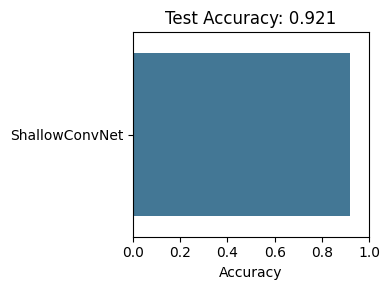

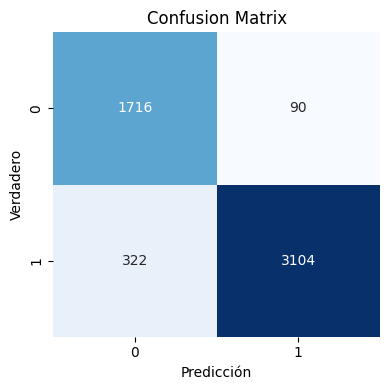

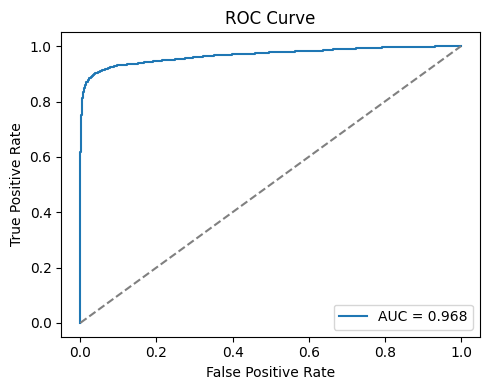

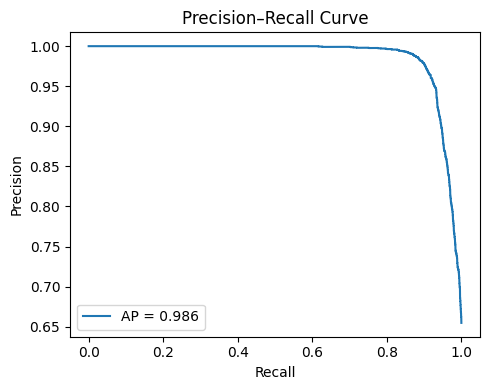

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    confusion_matrix,
    roc_curve, auc,
    precision_recall_curve, average_precision_score
)
import torch
import torch.nn as nn

# ————— Obtén predicciones y scores sobre el test set —————
model.eval()
softmax = nn.Softmax(dim=1)
y_true, y_pred, y_score = [], [], []

with torch.no_grad():
    for xb, yb in test_loader:
        xb = xb.to(device)
        out = model(xb)
        probs = softmax(out)[:, 1].cpu().numpy()    # probabilidad de clase “1” (enfermo)
        preds = out.argmax(1).cpu().numpy()
        y_true.extend(yb.numpy())
        y_pred.extend(preds)
        y_score.extend(probs)

y_true  = np.array(y_true)
y_pred  = np.array(y_pred)
y_score = np.array(y_score)

# ————— Cálcula métricas —————
acc       = (y_pred == y_true).mean()
cm        = confusion_matrix(y_true, y_pred)
fpr, tpr, _ = roc_curve(y_true, y_score)
roc_auc   = auc(fpr, tpr)
prec, rec, _ = precision_recall_curve(y_true, y_score)
pr_auc    = average_precision_score(y_true, y_score)

# ————— 1) Bar chart de Accuracy —————
plt.figure(figsize=(4,3))
sns.barplot(x=[acc], y=["ShallowConvNet"], orient="h", palette="mako")
plt.xlim(0,1)
plt.title(f"Test Accuracy: {acc:.3f}")
plt.xlabel("Accuracy")
plt.tight_layout()
plt.show()

# ————— 2) Matriz de confusión —————
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Confusion Matrix")
plt.xlabel("Predicción")
plt.ylabel("Verdadero")
plt.tight_layout()
plt.show()

# ————— 3) Curva ROC —————
plt.figure(figsize=(5,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1], "--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

# ————— 4) Curva Precision–Recall —————
plt.figure(figsize=(5,4))
plt.plot(rec, prec, label=f"AP = {pr_auc:.3f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend(loc="lower left")
plt.tight_layout()
plt.show()
